In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import wlcstat.wlc_copoly as wlc_copoly
import wlcstat.wlcstruc as wlcstruc

import sys
sys.path.append("./vertex_subroutines")
from GAMcalc import *  # Code for calculating vertex functions
import propagator  # propagator object used to store pre-calculated values
import wignerD as wd # wigner D object used to store pre-calculated values

import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

pset=propagator.prop_set(nlam=10) 

# $S^{(2)}$

In [2]:
def calc_monomer_matrix(poly_mat, dens):
    # calculates the AA monomer identity cross correlation matrix
    # assumes all polymers same length/ # of monomers, equal volume fraction of each
    
    #polymat - each row is a polymer
    #dens is an array where each entry is rel vol frac of correponding polymer
    if (np.sum(dens) != 1):
        raise Exception("polymer volumer fractions do not sum to one")
    if len(np.shape(poly_mat)) == 1: #single poly
        n_p = 1
        M = len(poly_mat)
        alph1 =np.zeros(M)
        alph2 =np.zeros(M)
        sig1 = 1*(poly_mat == alph1)
        sig2 = 1*(poly_mat == alph2)
        M2_AA = np.outer(sig1, sig2)
        return M2_AA
    
    n_p = poly_mat.shape[0]
    M = poly_mat.shape[1]
    alph1 =np.zeros((n_p, M))
    alph2 =np.zeros((n_p, M))
    
    #extend dens into n_pxM matrix
    poly_weights = (np.ones((n_p, M)).T * dens).T
    
    #multiply sigams by density of each polymer
    sigma1 = 1*((poly_mat == alph1))#.sum(axis = 0) #sigma. could multiply each
    sigma2 = 1*((poly_mat == alph2))#.sum(axis = 0)

    #need to do each row outer product with corresponding row, get n_p MxM matrices, then sum the results
    prods = np.einsum('bi,bo->bio', sigma1*poly_weights, sigma2) # performing row wise cross product (each poly contribution)
    M2_AA = np.sum(prods, axis = 0)#           ^^^^ averaging each contribution
    return M2_AA

In [3]:
def calc_sf2(poly_mat, dens, N_m=1, b=1, k_vec = np.logspace(-2, 2, 50)):
    #calculates all variations of the S(2) AA AB BB for a range of k
    M2_AA = calc_monomer_matrix(poly_mat, dens)
    M = np.shape(M2_AA)[0]
    nk = len(k_vec)

    one = np.ones((M,M))
    grid = np.indices((M, M))
    S2_AA_arr = np.zeros(nk)
    S2_AB_arr_fast = np.zeros(nk)
    S2_BB_arr_fast = np.zeros(nk)


    H_AA = np.diag(M2_AA)
    H_AA_mat = (H_AA * one)#.T removed T!!
    
    print("j1", grid[0])
    print("j2", grid[1])
    
    print(M2_AA)
    print(H_AA)
    print(H_AA * one)
    print(H_AA_mat)
    for i, k in enumerate(k_vec):
        C = np.zeros((M, M))
        x_m = (1/6) * N_m * b**2 * k**2

        #j1 = j2
        debye = (2/(x_m**2)) * (x_m + np.exp(-x_m) - 1) * (1/M**2)

        np.fill_diagonal(C, np.diag(one * debye))

        integral = (1/(x_m**2)) * (np.exp(x_m) + np.exp(-x_m) - 2) #for off-diagonal terms
        
        #j1 > j2
        j1minusj2_mat = grid[0] - grid[1]
        C += np.tril(one * np.exp(-x_m*(j1minusj2_mat)) * integral * (1/M**2), k = -1)

        #j2 > j1
        j2minusj1_mat = -1 * j1minusj2_mat
        C += np.triu(one * np.exp(-x_m*(j2minusj1_mat)) * integral * (1/M**2), k = 1) 
        
        
        S2_AA_arr[i] = np.sum(C * M2_AA)


        C_AB = H_AA_mat * C
        S2_AB_arr_fast[i] = np.sum(C_AB) - S2_AA_arr[i]
        S2_BB_arr_fast[i] = np.sum(C) + S2_AA_arr[i] - 2*np.sum(C_AB)
    return (S2_AA_arr, S2_AB_arr_fast, S2_BB_arr_fast)

In [4]:
def calc_sf2_inv(poly_mat, dens, N_m=1, b=1, k_vec = np.logspace(-2, 2, 50)):
    (S2_AA_arr, S2_AB_arr, S2_BB_arr) = calc_sf2(poly_mat, dens, N_m, b, k_vec)
    det = S2_AA_arr * S2_BB_arr - S2_AB_arr**2
    S2_AA_inv = S2_BB_arr * (1/det)
    S2_AB_inv = -S2_AB_arr * (1/det)
    S2_BB_inv = S2_AA_arr * (1/det)
    return (S2_AA_inv, S2_AB_inv, S2_BB_inv)

In [5]:
def find_kstar(poly_mat, dens, N_m=1, b=1, k_vec = np.logspace(-2, 2, 50)):
    (S2_AA_inv, S2_AB_inv, S2_BB_inv) = calc_sf2_inv(poly_mat, dens, N_m, b, k_vec)
    G2 = 0.5*(S2_AA_inv - 2* S2_AB_inv + S2_BB_inv) # chi = 0

    # eigvalues,eigvectors = np.linalg.eigh(G2)
    eigvalues_lst = G2
    min_eig = np.min(eigvalues_lst[~np.isnan(eigvalues_lst)])

    k_star = k_vec[np.where(eigvalues_lst==min_eig)]#[0]][0] 
    return k_star

### Identical homopolymers

In [6]:
%%time
poly_mat = np.array([[0,0],[0,0]]) # each row is a polymer
dens = np.array([0.5, 0.5])
N_m = 1
b = 1

M = poly_mat.shape[1]
k_vec = np.logspace(-2, 2, 50)

(S2_AA_arr, S2_AB_arr_fast, S2_BB_arr_fast) = calc_sf2(poly_mat, dens, N_m, b, k_vec)

j1 [[0 0]
 [1 1]]
j2 [[0 1]
 [0 1]]
[[1. 1.]
 [1. 1.]]
[1. 1.]
[[1. 1.]
 [1. 1.]]
[[1. 1.]
 [1. 1.]]
Wall time: 15 ms


In [7]:
N = N_m * M

x = (1/6) * N * b**2 * (k_vec**2)
debye_arr = (2/(x**2)) * (x + np.exp(-x) - 1) #* (1/N**2)

In [8]:
S2_AA_arr

array([0.99998935, 0.99998397, 0.9999765 , 0.9999656 , 0.99995002,
       0.99992723, 0.99989399, 0.99984563, 0.99977519, 0.99967263,
       0.99952329, 0.99930586, 0.99898932, 0.99852861, 0.99785823,
       0.99688312, 0.99546558, 0.99340655, 0.99041931, 0.98609295,
       0.97984292, 0.9708469 , 0.95796688, 0.9396667 , 0.91395077,
       0.87838051, 0.8302721 , 0.76722494, 0.68811378, 0.59446287,
       0.49158462, 0.38825487, 0.29403999, 0.21552071, 0.15447535,
       0.1091322 , 0.07637916, 0.05312633, 0.03680006, 0.02542003,
       0.01752598, 0.01206783, 0.00830222, 0.00570819, 0.00392305,
       0.00269542, 0.00185159,        nan,        nan,        nan])

In [9]:
s2AA_stat = wlcstruc.s2_wlc(k_vec, float(N))

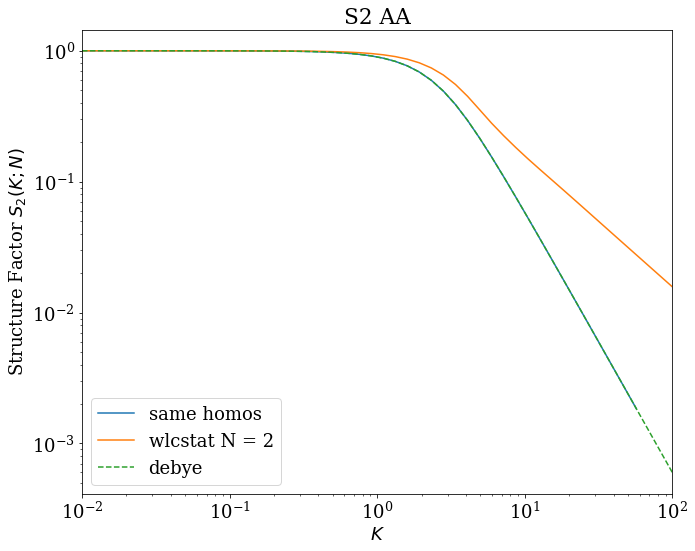

In [10]:
plt.figure(figsize=(10,8))
font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

plt.plot(k_vec, S2_AA_arr, label = "same homos")
plt.plot(k_vec, s2AA_stat, label = "wlcstat N = " + str(N))
plt.plot(k_vec, debye_arr, label = "debye", linestyle = "--")

plt.xscale('log')
plt.yscale('log')

plt.title("S2 AA")
plt.xlabel(r'$K$')
plt.ylabel(r'Structure Factor $S_{2}(K;N)$')
plt.xlim((1e-2, 1e2))
plt.tight_layout()
plt.legend()
plt.show()

### Monodisperse diblock 

In [13]:
%%time
poly_mat = np.array([[0,1],[0,1]]) # each row is a polymer
dens = np.array([0.5, 0.5])
N_m = 20
b = 1

M = poly_mat.shape[1]
nk = 50
k_vec = np.logspace(-2, 2, nk)

(S2_AA_arr, S2_AB_arr_fast, S2_BB_arr_fast) = calc_sf2(poly_mat, dens, N_m, b, k_vec)

j1 [[0 0]
 [1 1]]
j2 [[0 1]
 [0 1]]
[[1. 0.]
 [0. 0.]]
[1. 0.]
[[1. 0.]
 [1. 0.]]
[[1. 0.]
 [1. 0.]]
Wall time: 13 ms


In [14]:
# %%time
#VERTEX

FA =0.5
N = 40.
s2_arr_vert_AA = np.zeros(nk)
s2_arr_vert_AB = np.zeros(nk)
for i in range(nk):
    Ks = k_vec[i]
    s2_arr_vert_AA[i] = (s2wlc(pset, N, FA, Ks, sequence='all')/ (N**2))[0][0]
    s2_arr_vert_AB[i] = (s2wlc(pset, N, FA, Ks, sequence='all')/ (N**2))[0][1]

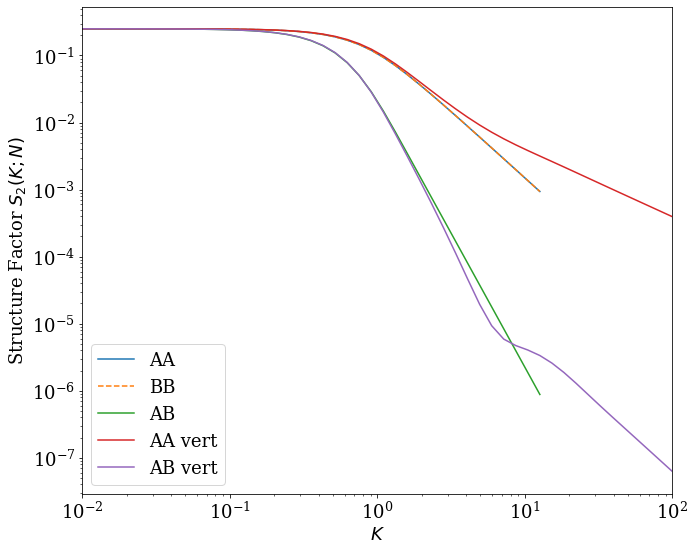

In [15]:
plt.figure(figsize=(10,8))
font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

plt.plot(k_vec, S2_AA_arr, label = "AA")
plt.plot(k_vec, S2_BB_arr_fast, label = "BB", linestyle = "--")
plt.plot(k_vec, S2_AB_arr_fast, label = "AB")

plt.plot(k_vec, s2_arr_vert_AA, label = "AA vert")
plt.plot(k_vec, s2_arr_vert_AB, label = "AB vert")

# plt.plot(k_vec, S2_BB_arr, label = "slow", linestyle = "--")
# plt.plot(k_vec, s2AA_stat, label = "wlcstat N = " + str(N))
# plt.plot(k_vec, debye_arr, label = "debye homo N = " + str(N), linestyle = "--")

plt.xscale('log')
plt.yscale('log')

# plt.title("S2")
plt.xlabel(r'$K$')
plt.ylabel(r'Structure Factor $S_{2}(K;N)$')
plt.xlim((1e-2, 1e2))
plt.tight_layout()
plt.legend()
plt.show()

#### stability analysis

In [16]:
find_kstar(poly_mat, dens, N_m=1, b=1, k_vec = np.logspace(-2, 2, 50))

j1 [[0 0]
 [1 1]]
j2 [[0 1]
 [0 1]]
[[1. 0.]
 [0. 0.]]
[1. 0.]
[[1. 0.]
 [1. 0.]]
[[1. 0.]
 [1. 0.]]


array([3.39322177])

In [17]:
# diblocks
det = S2_AA_arr * S2_BB_arr_fast - S2_AB_arr_fast**2
S2_AA_inv = S2_BB_arr_fast * (1/det)
S2_AB_inv = -S2_AB_arr_fast * (1/det)
S2_BB_inv = S2_AA_arr * (1/det)

# G2 = (0.5*np.array([[S2_AA_inv, S2_AB_inv], [S2_AB_inv, S2_BB_inv]])).T.reshape(len(k_vec), 2, 2) 

G2 = 0.5*(S2_AA_inv - 2* S2_AB_inv + S2_BB_inv) # chi = 0

# eigvalues,eigvectors = np.linalg.eigh(G2)
eigvalues_lst = G2
min_eig = np.min(eigvalues_lst[~np.isnan(eigvalues_lst)])

k_star = k_vec[np.where(eigvalues_lst==min_eig)]#[0]][0] 

In [18]:
k_star

array([0.75431201])

### Homopolymer mix

#### stability analysis

In [19]:
%%time
poly_mat = np.array([[1,1],[0,0]]) # each row is a polymer
dens = np.array([0.5, 0.5])
N_m = 1
b = 1

M = poly_mat.shape[1]
k_vec = np.logspace(-2, 2, 50)

(S2_AA_arr, S2_AB_arr_fast, S2_BB_arr_fast) = calc_sf2(poly_mat, dens, N_m, b, k_vec)

det = S2_AA_arr * S2_BB_arr_fast - S2_AB_arr_fast**2
S2_AA_inv = S2_BB_arr_fast * (1/det)
S2_AB_inv = -S2_AB_arr_fast * (1/det)
S2_BB_inv = S2_AA_arr * (1/det)

# G2 = (0.5*np.array([[S2_AA_inv, S2_AB_inv], [S2_AB_inv, S2_BB_inv]])).T.reshape(len(k_vec), 2, 2) 

G2 = 0.5*(S2_AA_inv - 2* S2_AB_inv + S2_BB_inv) # chi = 0

# eigvalues,eigvectors = np.linalg.eigh(G2)
eigvalues_lst = G2
min_eig = np.min(eigvalues_lst[~np.isnan(eigvalues_lst)])

k_star = k_vec[np.where(eigvalues_lst==min_eig)]#[0]][0] 

j1 [[0 0]
 [1 1]]
j2 [[0 1]
 [0 1]]
[[0.5 0.5]
 [0.5 0.5]]
[0.5 0.5]
[[0.5 0.5]
 [0.5 0.5]]
[[0.5 0.5]
 [0.5 0.5]]
Wall time: 14 ms


In [20]:
find_kstar(poly_mat, dens, N_m=1, b=1, k_vec = np.logspace(-2, 2, 50))

j1 [[0 0]
 [1 1]]
j2 [[0 1]
 [0 1]]
[[0.5 0.5]
 [0.5 0.5]]
[0.5 0.5]
[[0.5 0.5]
 [0.5 0.5]]
[[0.5 0.5]
 [0.5 0.5]]


array([0.01])

In [21]:
k_star

array([0.01])

In [22]:
#TODO:
# -find full spinodal of monodisperse diblock, compare to vertex/Leibler (verification)
# -vectorize wrt k? using curvature to determine mirco vs macro phase sep?
# -S3, S4

# $S^{(3)}$

In [23]:
def calc_sf3_homo(N=1, b=1, k_vec = np.logspace(-2, 2, 50), k_vec_2 = np.logspace(-2, 2, 50)):
    nk = len(k_vec)

    one = np.ones((M,M,M))
    grid = np.indices((M,M,M))
    j1 = grid[0]
    j2 = grid[1]
    j3 = grid[2]
    
    S3_homo_arr = np.zeros(nk)
    
    for i, k_1 in enumerate(k_vec):
        k_2 = k_vec_2[i]
        k_12 = k_1 + k_2
        
        # case 1 kA = k1 + k2, kB = k_1;   (assigning kA or kB doesnt matter)
        # case 2 kA = k2,      kB = k1 + k2; 
        # case 3 kA = k2,      kB = -k1
        
        k_cases = np.array([[k_1 + k_2, k_1], [k_2, k_1 + k_2], [k_2, -k_1]])
        
        # for each case and sub case, add to a matrix C(j1, j2, j3) which contains the contribution to the overall S3
        # then sum over all indices
        C = np.zeros((M,M,M))

        for kA, kB in k_cases:            
            xm_A = (1/6) * b**2 * np.linalg.norm(kA)**2 #k_1**2  #NOTE THIS XM is NEGATIVE
            xm_B = (1/6) * b**2 * np.linalg.norm(kB)**2
            
            #due to mathematica expontential integral issue, need to treat k_A == k_B separately
            cylindrical = False
            epsilon = 0.0000001
            if xm_A + epsilon > xm_B and xm_A - epsilon < xm_B:
                cylindrical = True
                        
            # ONLY case; s3>s2>s1 

            if cylindrical == True:
                integral = (1 / xm_A**3) * (np.exp(-N*xm_A) * (2 + np.exp(N*xm_A)*(-2 + N*xm_A) + N*xm_A))
            else:
                integral = (1 / (xm_A**2 * xm_B - xm_A * xm_B**2))\
                * ( N*xm_A + (((-1 + np.exp(-N*xm_B)) * xm_A)/(xm_B)) - N*xm_B + ((xm_B - np.exp(-N*xm_A)*xm_B)/(xm_A)) )
            
            S3_homo_arr[i] += 2 * (1/N**3) * integral
            
    return S3_homo_arr

In [24]:
def calc_monomer_matrix_3(poly_mat, dens):
    # calculates the AAA monomer identity cross correlation matrix
    # assumes all polymers same length/ # of monomers, equal volume fraction of each
    
    # polymat - each row is a polymer
    # dens is an array where each entry is rel vol frac of correponding polymer
    if (np.sum(dens) != 1):
        raise Exception("polymer volumer fractions do not sum to one")
    if len(np.shape(poly_mat)) == 1: # single poly
        n_p = 1
        M = len(poly_mat)
        alph1 =np.zeros(M)
        alph2 =np.zeros(M)
        alph3 =np.zeros(M)
        sig1 = 1*(poly_mat == alph1)
        sig2 = 1*(poly_mat == alph2)
        sig3 = 1*(poly_mat == alph3)
#         M2_AA = np.outer(sig1, sig2)
        M3_AAA = np.einsum('i,j,k',sig1,sig2,sig3)
        return M3_AAA
    
    n_p = poly_mat.shape[0]
    M = poly_mat.shape[1]
    alph1 =np.zeros((n_p, M))
    alph2 =np.zeros((n_p, M))
    alph3 =np.zeros((n_p, M))

    
    #extend dens into n_pxM matrix
    poly_weights = (np.ones((n_p, M)).T * dens).T
    
    #multiply sigams by density of each polymer
    sigma1 = 1*((poly_mat == alph1))#.sum(axis = 0) #sigma. could multiply each
    sigma2 = 1*((poly_mat == alph2))#.sum(axis = 0)
    sigma3 = 1*((poly_mat == alph3))
    
    #need to do each row outer product with corresponding row, get n_p MxMxM matrices, then sum the results
    prods = np.einsum('bi,bo,bn->bion', sigma1*poly_weights, sigma2, sigma3) # performing row wise cross product (each poly contribution)
    M3_AAA = np.sum(prods, axis = 0)#           ^^^^ averaging each contribution
    return M3_AAA

In [203]:
#TODO- simlify function calls- some are redundant, only index changes
def calc_sf3_exp(poly_mat, dens, N_m=1, b=1, k_vec = np.logspace(-2, 2, 50), k_vec_2 = np.logspace(-2, 2, 50)):
    M3_AAA = calc_monomer_matrix_3(poly_mat, dens)
    M = np.shape(M3_AAA)[0]
    nk = len(k_vec)

    one = np.ones((M,M,M))
    grid = np.indices((M,M,M))
    j1 = grid[0]
    j2 = grid[1]
    j3 = grid[2]
    
    S3_AAA_arr = np.zeros(nk)
    S3_AAB_arr = np.zeros(nk)
    S3_ABB_arr = np.zeros(nk)
    S3_BBB_arr = np.zeros(nk)
    
    M3_BAA = M3_AAA[j2, j2, j3] - M3_AAA
    M3_BBA = M3_AAA + M3_BAA_fast[j1, j3, j3] - M3_AAA[j2,j2,j3]
    M3_BBB = 1  - M3_AAA[j1, j1, j1] - M3_BAA_fast[j1, j2, j2] - M3_BAA_fast[j1, j3, j3] + M3_AAA[j2,j2,j3] - M3_AAA
    
    for i, k_1 in enumerate(k_vec):
        k_2 = k_vec_2[i]
        k_12 = k_1 + k_2
        
        # case 1 kA = k1 + k2, kB = k_1;   (assigning kA or kB doesnt matter)
        # case 2 kA = k2,      kB = k1 + k2; 
        # case 3 kA = k2,      kB = -k1
        
        k_cases = np.array([[k_1 + k_2, k_1], [k_2, k_1 + k_2], [k_2, -k_1]])
        
        # for each case and sub case, add to a matrix C(j1, j2, j3) which contains the contribution to the overall S3
        # then sum over all indices
        C = np.zeros((M,M,M))
        
        # CASE 1; kA = k1 + k2, kB = k_1; S3 > S2 > S1
        kA, kB = k_cases[0]
        xm_A = (1/6) * N_m * b**2 * np.linalg.norm(kA)**2
        xm_B = (1/6) * N_m * b**2 * np.linalg.norm(kB)**2
        
        C = case1(C, N_m, b, xm_A, xm_B, M)
        C = case1deg(C, N_m, b, xm_A, xm_B, M)

        # CASE 2; kA = k2, kB = k1 + k2; S2 > S1 > S3
        
        kA, kB = k_cases[1]
        xm_A = (1/6) * N_m * b**2 * np.linalg.norm(kA)**2
        xm_B = (1/6) * N_m * b**2 * np.linalg.norm(kB)**2
        
        C = case2(C, N_m, b, xm_A, xm_B, M)
        C = case2deg(C, N_m, b, xm_A, xm_B, M)
        # CASE 3; kA = k2, kB = -k1; S2 > S3 > S1
        
        kA, kB = k_cases[2]
        xm_A = (1/6) * N_m * b**2 * np.linalg.norm(kA)**2
        xm_B = (1/6) * N_m * b**2 * np.linalg.norm(kB)**2
        
        C = case3(C, N_m, b, xm_A, xm_B, M)
        C = case3deg(C, N_m, b, xm_A, xm_B, M)

        S3_AAA_arr[i] += np.sum((1/M**3) * M3_AAA* C)
        S3_AAB_arr[i] += np.sum((1/M**3) * M3_BAA* C)
        S3_ABB_arr[i] += np.sum((1/M**3) * M3_BBA* C)
        S3_BBB_arr[i] += np.sum((1/M**3) * M3_BBB* C)  
        
    return S3_AAA_arr, S3_AAB_arr, S3_ABB_arr, S3_BBB_arr

In [184]:
# S3 > S2 > S1
def case1(C, N_m, b, xm_A, xm_B, M,):
    
    grid = np.indices((M,M,M))
    j1 = grid[0]
    j2 = grid[1]
    j3 = grid[2]
    
    cylindrical = False
    epsilon = 0.0000001
    if xm_A + epsilon > xm_B and xm_A - epsilon < xm_B:
        cylindrical = True
    constant = np.exp(-xm_A*(j3 - j2)) * np.exp(-xm_B*(j2 - j1)) 

    # sub case 1; j3 > j2 > j1, {s1, s2, s3} any 
    index = (j3 > j2) * (j2 > j1)

    if cylindrical == True:
        integral = (1 / xm_A**2) * 2 * (-1 + np.cosh(xm_A))
    else:
        integral = (-2 / (xm_A * (xm_A - xm_B) * xm_B)) \
        * (-np.sinh(xm_A) + np.sinh(xm_A - xm_B) + np.sinh(xm_B))

    C[np.where(index != 0)] += 1 \
                                    * constant[np.where(index != 0)] \
                                    * integral \
                                    * 1 # degeneracy from switching js


    # sub case 2; j3 = j2 > j1, s3 > s2, {s1} any
    index = (j3 == j2) * (j2 > j1)

    if cylindrical == True:
        integral = (1 / xm_A**3) *( (2 + xm_A) * (-1 + np.cosh(xm_A)) - (xm_A * np.sinh(xm_A)) )
    else:
        integral = ((-1 + np.exp(xm_B))/(xm_A * (xm_A - xm_B)*xm_B**2)) \
        * (xm_A + (-1 + np.exp(-xm_A))*xm_B - xm_A*np.cosh(xm_B) + xm_A*np.sinh(xm_B))

    C[np.where(index != 0)] += 1 \
                                    * constant[np.where(index != 0)] \
                                    * integral \
                                    * 1 # degeneracy 
 

    # BONUS sub case 4; j3 > j2 = j1, s2 > s1, {s3} any 
    index = (j3 > j2) * (j2 == j1)

    if cylindrical == True:
        integral = (1 / xm_A**3) *( (2 + xm_A) * (-1 + np.cosh(xm_A)) - (xm_A * np.sinh(xm_A)) )
    else:
        integral = (((-1 + np.exp(xm_A))*(np.exp(-xm_A - xm_B)))/(xm_B * (xm_A - xm_B)*xm_A**2)) \
        * (-np.exp(xm_A)*xm_A + np.exp(xm_A + xm_B) * (xm_A -xm_B) + np.exp(xm_B)*xm_B)

    C[np.where(index != 0)] += 1 \
                                    * constant[np.where(index != 0)] \
                                    * integral \
                                    * 1 # degeneracy from swiching j2 j1, s2 s1


    # sub case 3; j3 = j2 = j1, s3 > s2 > s1
    index = (j3 == j2) * (j2 == j1)

    if cylindrical == True:
        integral = (1 / xm_A**3) * (np.exp(-xm_A) * (2 + np.exp(xm_A)*(-2 + xm_A) + xm_A))
    else:
        integral = (1 / (xm_A**2 * xm_B - xm_A * xm_B**2))\
        * ( xm_A + (((-1 + np.exp(-xm_B)) * xm_A)/(xm_B)) - xm_B + ((xm_B - np.exp(-xm_A)*xm_B)/(xm_A)) )

    C[np.where(index != 0)] += 1\
                                    * constant[np.where(index != 0)]\
                                    * integral \
                                    * 1 
 
    return C

In [185]:
# S3 > S1 > S2
def case1deg(C, N_m, b, xm_A, xm_B, M):
    
    grid = np.indices((M,M,M))
    j1 = grid[0]
    j2 = grid[1]
    j3 = grid[2]
    
    cylindrical = False
    epsilon = 0.0000001
    if xm_A + epsilon > xm_B and xm_A - epsilon < xm_B:
        cylindrical = True
    constant = np.exp(-xm_A*(j3 - j1)) * np.exp(-xm_B*(j1 - j2)) 

    # sub case 1; j3 > j2 > j1, {s1, s2, s3} any 
    index = (j3 > j1) * (j1 > j2)

    if cylindrical == True:
        integral = (1 / xm_A**2) * 2 * (-1 + np.cosh(xm_A))
    else:
        integral = (-2 / (xm_A * (xm_A - xm_B) * xm_B)) \
        * (-np.sinh(xm_A) + np.sinh(xm_A - xm_B) + np.sinh(xm_B))

    C[np.where(index != 0)] += 1 \
                                    * constant[np.where(index != 0)] \
                                    * integral \
                                    * 1 # degeneracy from switching js


    # sub case 2; j3 = j2 > j1, s3 > s2, {s1} any
    index = (j3 == j1) * (j1 > j2)

    if cylindrical == True:
        integral = (1 / xm_A**3) *( (2 + xm_A) * (-1 + np.cosh(xm_A)) - (xm_A * np.sinh(xm_A)) )
    else:
        integral = ((-1 + np.exp(xm_B))/(xm_A * (xm_A - xm_B)*xm_B**2)) \
        * (xm_A + (-1 + np.exp(-xm_A))*xm_B - xm_A*np.cosh(xm_B) + xm_A*np.sinh(xm_B))

    C[np.where(index != 0)] += 1 \
                                    * constant[np.where(index != 0)] \
                                    * integral \
                                    * 1 # degeneracy 
 

    # BONUS sub case 4; j3 > j2 = j1, s2 > s1, {s3} any 
    index = (j3 > j1) * (j1 == j2)

    if cylindrical == True:
        integral = (1 / xm_A**3) *( (2 + xm_A) * (-1 + np.cosh(xm_A)) - (xm_A * np.sinh(xm_A)) )
    else:
        integral = (((-1 + np.exp(xm_A))*(np.exp(-xm_A - xm_B)))/(xm_B * (xm_A - xm_B)*xm_A**2)) \
        * (-np.exp(xm_A)*xm_A + np.exp(xm_A + xm_B) * (xm_A -xm_B) + np.exp(xm_B)*xm_B)

    C[np.where(index != 0)] += 1 \
                                    * constant[np.where(index != 0)] \
                                    * integral \
                                    * 1 # degeneracy from swiching j2 j1, s2 s1


    # sub case 3; j3 = j2 = j1, s3 > s2 > s1
    index = (j3 == j1) * (j1 == j2)

    if cylindrical == True:
        integral = (1 / xm_A**3) * (np.exp(-xm_A) * (2 + np.exp(xm_A)*(-2 + xm_A) + xm_A))
    else:
        integral = (1 / (xm_A**2 * xm_B - xm_A * xm_B**2))\
        * ( xm_A + (((-1 + np.exp(-xm_B)) * xm_A)/(xm_B)) - xm_B + ((xm_B - np.exp(-xm_A)*xm_B)/(xm_A)) )

    C[np.where(index != 0)] += 1\
                                    * constant[np.where(index != 0)]\
                                    * integral \
                                    * 1 

    return C

In [186]:
# kA = k2, kB = k1 + k2; S2 > S1 > S3
# case1 3>2>1
# 3 -> 2
# 2 -> 1
# 1 -> 3
def case2(C, N_m, b, xm_A, xm_B, M):
    
    grid = np.indices((M,M,M))
    j1 = grid[0]
    j2 = grid[1]
    j3 = grid[2]
    
    cylindrical = False
    epsilon = 0.0000001
    if xm_A + epsilon > xm_B and xm_A - epsilon < xm_B:
        cylindrical = True
    constant = np.exp(-xm_A*(j2 - j1)) * np.exp(-xm_B*(j1 - j3)) 

    # sub case 1; j2 > j1 > j3, {s1, s2, s3} any 
    index = (j2 > j1) * (j1 > j3)

    if cylindrical == True:
        integral = (1 / xm_A**2) * 2 * (-1 + np.cosh(xm_A))
    else:
        integral = (-2 / (xm_A * (xm_A - xm_B) * xm_B)) \
        * (-np.sinh(xm_A) + np.sinh(xm_A - xm_B) + np.sinh(xm_B))

    C[np.where(index != 0)] += 1 \
                                    * constant[np.where(index != 0)] \
                                    * integral \
                                    * 1 # degeneracy from switching js


    # sub case 2; j2 = j1 > j3, s2 > s1, {s3} any
    index = (j2 == j1) * (j1 > j3)

    if cylindrical == True:
        integral = (1 / xm_A**3) *( (2 + xm_A) * (-1 + np.cosh(xm_A)) - (xm_A * np.sinh(xm_A)) )
    else:
        integral = ((-1 + np.exp(xm_B))/(xm_A * (xm_A - xm_B)*xm_B**2)) \
        * (xm_A + (-1 + np.exp(-xm_A))*xm_B - xm_A*np.cosh(xm_B) + xm_A*np.sinh(xm_B))

    C[np.where(index != 0)] += 1 \
                                    * constant[np.where(index != 0)] \
                                    * integral \
                                    * 1 # degeneracy 


    # BONUS sub case 4; j2 > j1 = j3, s1 > s3, {s2} any 
    index = (j2 > j1) * (j1 == j3)

    if cylindrical == True:
        integral = (1 / xm_A**3) *( (2 + xm_A) * (-1 + np.cosh(xm_A)) - (xm_A * np.sinh(xm_A)) )
    else:
        integral = (((-1 + np.exp(xm_A))*(np.exp(-xm_A - xm_B)))/(xm_B * (xm_A - xm_B)*xm_A**2)) \
        * (-np.exp(xm_A)*xm_A + np.exp(xm_A + xm_B) * (xm_A -xm_B) + np.exp(xm_B)*xm_B)

    C[np.where(index != 0)] += 1 \
                                    * constant[np.where(index != 0)] \
                                    * integral \
                                    * 1 # degeneracy from swiching j2 j1, s2 s1

    # sub case 3; j3 = j2 = j1, s2 > s1 > s3
    index = (j3 == j2) * (j2 == j1)

    if cylindrical == True:
        integral = (1 / xm_A**3) * (np.exp(-xm_A) * (2 + np.exp(xm_A)*(-2 + xm_A) + xm_A))
    else:
        integral = (1 / (xm_A**2 * xm_B - xm_A * xm_B**2))\
        * ( xm_A + (((-1 + np.exp(-xm_B)) * xm_A)/(xm_B)) - xm_B + ((xm_B - np.exp(-xm_A)*xm_B)/(xm_A)) )

    C[np.where(index != 0)] += 1\
                                    * constant[np.where(index != 0)]\
                                    * integral \
                                    * 1 

    return C

In [187]:
# kA = k2, kB = k1 + k2; S1 > S2 > S3
# case1 3>2>1
# 3 -> 2
# 2 -> 1
# 1 -> 3
def case2deg(C, N_m, b, xm_A, xm_B, M):
    
    grid = np.indices((M,M,M))
    j1 = grid[0]
    j2 = grid[1]
    j3 = grid[2]
    
    cylindrical = False
    epsilon = 0.0000001
    if xm_A + epsilon > xm_B and xm_A - epsilon < xm_B:
        cylindrical = True
    constant = np.exp(-xm_A*(j1 - j2)) * np.exp(-xm_B*(j2 - j3)) 

    # sub case 1; j2 > j1 > j3, {s1, s2, s3} any 
    index = (j1 > j2) * (j2 > j3)

    if cylindrical == True:
        integral = (1 / xm_A**2) * 2 * (-1 + np.cosh(xm_A))
    else:
        integral = (-2 / (xm_A * (xm_A - xm_B) * xm_B)) \
        * (-np.sinh(xm_A) + np.sinh(xm_A - xm_B) + np.sinh(xm_B))

    C[np.where(index != 0)] += 1 \
                                    * constant[np.where(index != 0)] \
                                    * integral \
                                    * 1 # degeneracy from switching js


    # sub case 2; j2 = j1 > j3, s2 > s1, {s3} any
    index = (j1 == j2) * (j2 > j3)

    if cylindrical == True:
        integral = (1 / xm_A**3) *( (2 + xm_A) * (-1 + np.cosh(xm_A)) - (xm_A * np.sinh(xm_A)) )
    else:
        integral = ((-1 + np.exp(xm_B))/(xm_A * (xm_A - xm_B)*xm_B**2)) \
        * (xm_A + (-1 + np.exp(-xm_A))*xm_B - xm_A*np.cosh(xm_B) + xm_A*np.sinh(xm_B))

    C[np.where(index != 0)] += 1 \
                                    * constant[np.where(index != 0)] \
                                    * integral \
                                    * 1 # degeneracy 
    

    # BONUS sub case 4; j2 > j1 = j3, s1 > s3, {s2} any 
    index = (j1 > j2) * (j2 == j3)

    if cylindrical == True:
        integral = (1 / xm_A**3) *( (2 + xm_A) * (-1 + np.cosh(xm_A)) - (xm_A * np.sinh(xm_A)) )
    else:
        integral = (((-1 + np.exp(xm_A))*(np.exp(-xm_A - xm_B)))/(xm_B * (xm_A - xm_B)*xm_A**2)) \
        * (-np.exp(xm_A)*xm_A + np.exp(xm_A + xm_B) * (xm_A -xm_B) + np.exp(xm_B)*xm_B)

    C[np.where(index != 0)] += 1 \
                                    * constant[np.where(index != 0)] \
                                    * integral \
                                    * 1 # degeneracy from swiching j2 j1, s2 s1


    # sub case 3; j3 = j2 = j1, s2 > s1 > s3
    index = (j3 == j2) * (j2 == j1)

    if cylindrical == True:
        integral = (1 / xm_A**3) * (np.exp(-xm_A) * (2 + np.exp(xm_A)*(-2 + xm_A) + xm_A))
    else:
        integral = (1 / (xm_A**2 * xm_B - xm_A * xm_B**2))\
        * ( xm_A + (((-1 + np.exp(-xm_B)) * xm_A)/(xm_B)) - xm_B + ((xm_B - np.exp(-xm_A)*xm_B)/(xm_A)) )

    C[np.where(index != 0)] += 1\
                                    * constant[np.where(index != 0)]\
                                    * integral \
                                    * 1 

    return C 

In [188]:
#  S2 > S3 > S1

# 3 -> 1
# 1 -> 3
def case3(C, N_m, b, xm_A, xm_B, M):
    
    grid = np.indices((M,M,M))
    j1 = grid[0]
    j2 = grid[1]
    j3 = grid[2]
    
    cylindrical = False
    epsilon = 0.0000001
    if xm_A + epsilon > xm_B and xm_A - epsilon < xm_B:
        cylindrical = True
    constant = np.exp(-xm_A*(j2 - j3)) * np.exp(-xm_B*(j3 - j1)) 

    # sub case 1; j2 > j3 > j1, {s1, s2, s3} any 
    index = (j2 > j3) * (j3 > j1)

    if cylindrical == True:
        integral = (1 / xm_A**2) * 2 * (-1 + np.cosh(xm_A))
    else:
        integral = (-2 / (xm_A * (xm_A - xm_B) * xm_B)) \
        * (-np.sinh(xm_A) + np.sinh(xm_A - xm_B) + np.sinh(xm_B))

    C[np.where(index != 0)] += 1 \
                                    * constant[np.where(index != 0)] \
                                    * integral \
                                    * 1 # degeneracy from switching js

    # sub case 2; j2 = j3 > j1, s2 > s3, {s1} any
    index = (j2 == j3) * (j3 > j1)

    if cylindrical == True:
        integral = (1 / xm_A**3) *( (2 + xm_A) * (-1 + np.cosh(xm_A)) - (xm_A * np.sinh(xm_A)) )
    else:
        integral = ((-1 + np.exp(xm_B))/(xm_A * (xm_A - xm_B)*xm_B**2)) \
        * (xm_A + (-1 + np.exp(-xm_A))*xm_B - xm_A*np.cosh(xm_B) + xm_A*np.sinh(xm_B))

    C[np.where(index != 0)] += 1 \
                                    * constant[np.where(index != 0)] \
                                    * integral \
                                    * 1 # degeneracy  

    # BONUS sub case 4; j2 > j3 = j1, s3 > s1, {s2} any 
    index = (j2 > j3) * (j3 == j1)

    if cylindrical == True:
        integral = (1 / xm_A**3) *( (2 + xm_A) * (-1 + np.cosh(xm_A)) - (xm_A * np.sinh(xm_A)) )
    else:
        integral = (((-1 + np.exp(xm_A))*(np.exp(-xm_A - xm_B)))/(xm_B * (xm_A - xm_B)*xm_A**2)) \
        * (-np.exp(xm_A)*xm_A + np.exp(xm_A + xm_B) * (xm_A -xm_B) + np.exp(xm_B)*xm_B)
    
    C[np.where(index != 0)] += 1 \
                                    * constant[np.where(index != 0)] \
                                    * integral \
                                    * 1 # degeneracy from swiching j2 j1, s2 s1

    # sub case 3; j3 = j2 = j1, s2 > s3 > s1
    index = (j3 == j2) * (j2 == j1)

    if cylindrical == True:
        integral = (1 / xm_A**3) * (np.exp(-xm_A) * (2 + np.exp(xm_A)*(-2 + xm_A) + xm_A))
    else:
        integral = (1 / (xm_A**2 * xm_B - xm_A * xm_B**2))\
        * ( xm_A + (((-1 + np.exp(-xm_B)) * xm_A)/(xm_B)) - xm_B + ((xm_B - np.exp(-xm_A)*xm_B)/(xm_A)) )

    C[np.where(index != 0)] += 1\
                                    * constant[np.where(index != 0)]\
                                    * integral \
                                    * 1 

    return C 

In [189]:
#  S1 > S3 > S2
def case3deg(C, N_m, b, xm_A, xm_B, M):
    
    grid = np.indices((M,M,M))
    j1 = grid[0]
    j2 = grid[1]
    j3 = grid[2]
    
    cylindrical = False
    epsilon = 0.0000001
    if xm_A + epsilon > xm_B and xm_A - epsilon < xm_B:
        cylindrical = True
    constant = np.exp(-xm_A*(j1 - j3)) * np.exp(-xm_B*(j3 - j2)) 

    # sub case 1; j2 > j3 > j1, {s1, s2, s3} any 
    index = (j1 > j3) * (j3 > j2)

    if cylindrical == True:
        integral = (1 / xm_A**2) * 2 * (-1 + np.cosh(xm_A))
    else:
        integral = (-2 / (xm_A * (xm_A - xm_B) * xm_B)) \
        * (-np.sinh(xm_A) + np.sinh(xm_A - xm_B) + np.sinh(xm_B))

    C[np.where(index != 0)] += 1 \
                                    * constant[np.where(index != 0)] \
                                    * integral \
                                    * 1 # degeneracy from switching js

    # sub case 2; j2 = j3 > j1, s2 > s3, {s1} any
    index = (j1 == j3) * (j3 > j2)

    if cylindrical == True:
        integral = (1 / xm_A**3) *( (2 + xm_A) * (-1 + np.cosh(xm_A)) - (xm_A * np.sinh(xm_A)) )
    else:
        integral = ((-1 + np.exp(xm_B))/(xm_A * (xm_A - xm_B)*xm_B**2)) \
        * (xm_A + (-1 + np.exp(-xm_A))*xm_B - xm_A*np.cosh(xm_B) + xm_A*np.sinh(xm_B))

    C[np.where(index != 0)] += 1 \
                                    * constant[np.where(index != 0)] \
                                    * integral \
                                    * 1 # degeneracy 
    
    # BONUS sub case 4; j2 > j3 = j1, s3 > s1, {s2} any 
    index = (j1 > j3) * (j3 == j2)

    if cylindrical == True:
        integral = (1 / xm_A**3) *( (2 + xm_A) * (-1 + np.cosh(xm_A)) - (xm_A * np.sinh(xm_A)) )
    else:
        integral = (((-1 + np.exp(xm_A))*(np.exp(-xm_A - xm_B)))/(xm_B * (xm_A - xm_B)*xm_A**2)) \
        * (-np.exp(xm_A)*xm_A + np.exp(xm_A + xm_B) * (xm_A -xm_B) + np.exp(xm_B)*xm_B)
    
    C[np.where(index != 0)] += 1 \
                                    * constant[np.where(index != 0)] \
                                    * integral \
                                    * 1 # degeneracy from swiching j2 j1, s2 s1

    # sub case 3; j3 = j2 = j1, s2 > s3 > s1
    index = (j3 == j1) * (j1 == j2)

    if cylindrical == True:
        integral = (1 / xm_A**3) * (np.exp(-xm_A) * (2 + np.exp(xm_A)*(-2 + xm_A) + xm_A))
    else:
        integral = (1 / (xm_A**2 * xm_B - xm_A * xm_B**2))\
        * ( xm_A + (((-1 + np.exp(-xm_B)) * xm_A)/(xm_B)) - xm_B + ((xm_B - np.exp(-xm_A)*xm_B)/(xm_A)) )

    C[np.where(index != 0)] += 1\
                                    * constant[np.where(index != 0)]\
                                    * integral \
                                    * 1 
    return C 

In [190]:
#TODO- ask about degeneracy done correctly, HOW TO VERIFY AAA????
#, figure out AAB
def calc_sf3_NEWEST(poly_mat, dens, N_m=1, b=1, k_vec = np.logspace(-2, 2, 50), k_vec_2 = np.logspace(-2, 2, 50)):
    M3_AAA = calc_monomer_matrix_3(poly_mat, dens)
    M = np.shape(M3_AAA)[0]
    nk = len(k_vec)

    one = np.ones((M,M,M))
    grid = np.indices((M,M,M))
    j1 = grid[0]
    j2 = grid[1]
    j3 = grid[2]
    
    S3_AAA_arr = np.zeros(nk)
    S3_AAB_arr_fast = np.zeros(nk)
    S3_ABB_arr_fast = np.zeros(nk)
    S3_BBB_arr_fast = np.zeros(nk)
    
    S3_AAA_arr_ALT = np.zeros(nk)
    
    S3_AAA_arr_ALT_ALT = np.zeros(nk)
    
    #gives MAAA (j2, j2, j3)
    init = [M3_AAA[j1 == j2].reshape((M, M))]
    M3_AAA_j2j2j3 = init
    for i in range(M-1):
        M3_AAA_j2j2j3 = np.vstack((M3_AAA_j2j2j3, init))
#     print("difference")
#     print(M3_AAA_j2j2j3 - M3_AAA)
    M3_BAA = M3_AAA_j2j2j3 - M3_AAA
#     #gives MAAA (j1, j3, j3)  # NOT CORRECT!!!!!!!
#     init = [M3_AAA[j3 == j2].reshape((M, M))]
#     M3_AAA_j1j3j3 = init
#     for i in range(M-1):
#         M3_AAA_j1j3j3 = np.vstack((M3_AAA_j1j3j3, init))
    
    for i, k_1 in enumerate(k_vec):
        k_2 = k_vec_2[i]
        k_12 = k_1 + k_2
        
        # case 1 kA = k1 + k2, kB = k_1;   (assigning kA or kB doesnt matter)
        # case 2 kA = k2,      kB = k1 + k2; 
        # case 3 kA = k2,      kB = -k1
        
        k_cases = np.array([[k_1 + k_2, k_1], [k_2, k_1 + k_2], [k_2, -k_1]])
        
        # for each case and sub case, add to a matrix C(j1, j2, j3) which contains the contribution to the overall S3
        # then sum over all indices
        C = np.zeros((M,M,M))
        
        # for S3_AAB
        C2 = np.zeros((M,M,M))
        C9000 = np.zeros((M,M,M))
        Csad = np.zeros((M,M,M))

        for kA, kB in k_cases:            
            xm_A = (1/6) * N_m * b**2 * np.linalg.norm(kA)**2 #k_1**2  #NOTE THIS XM is NEGATIVE
            xm_B = (1/6) * N_m * b**2 * np.linalg.norm(kB)**2

            #due to mathematica expontential integral issue, need to treat k_A == k_B separately
            cylindrical = False
            epsilon = 0.0000001
            if xm_A + epsilon > xm_B and xm_A - epsilon < xm_B:
                cylindrical = True

            # this math is for case 1; S3 > S2 > S1
            
            constant = np.exp(-xm_A*(j3 - j2)) * np.exp(-xm_B*(j2 - j1)) 
            
            # sub case 1; j3 > j2 > j1, {s1, s2, s3} any 
            index = (j3 > j2) * (j2 > j1)

            if cylindrical == True:
                integral = (1 / xm_A**2) * 2 * (-1 + np.cosh(xm_A))
            else:
                integral = (-2 / (xm_A * (xm_A - xm_B) * xm_B)) \
                * (-np.sinh(xm_A) + np.sinh(xm_A - xm_B) + np.sinh(xm_B))
            
            C[np.where(index != 0)] += M3_AAA[np.where(index != 0)] \
                                            * constant[np.where(index != 0)] \
                                            * integral \
                                            * 2 # degeneracy from switching js
            
            C2[np.where(index != 0)] += M3_AAA_j2j2j3[np.where(index != 0)] \
                                            * constant[np.where(index != 0)] \
                                            * integral \
                                            * 2 
            
            C9000[np.where(index != 0)] += constant[np.where(index != 0)] \
                                            * integral \
                                            * 0.5
            
            Csad[np.where(index != 0)] += M3_BAA[np.where(index != 0)] \
                                            * constant[np.where(index != 0)] \
                                            * integral \
                                            * 2 

#             S3_AAA_arr_ALT_ALT[i] += np.sum((2/M**3)*M3_AAA[np.where(index != 0)] \
#                                             * constant[np.where(index != 0)] \
#                                             * integral)
            # sub case 2; j3 = j2 > j1, s3 > s2, {s1} any
            index = (j3 == j2) * (j2 > j1)

            if cylindrical == True:
                integral = (1 / xm_A**3) *( (2 + xm_A) * (-1 + np.cosh(xm_A)) - (xm_A * np.sinh(xm_A)) )
            else:
                integral = ((-1 + np.exp(xm_B))/(xm_A * (xm_A - xm_B)*xm_B**2)) \
                * (xm_A + (-1 + np.exp(-xm_A))*xm_B - xm_A*np.cosh(xm_B) + xm_A*np.sinh(xm_B))
            
            C[np.where(index != 0)] += M3_AAA[np.where(index != 0)] \
                                            * constant[np.where(index != 0)] \
                                            * integral \
                                            * 2 # degeneracy 
            
            C2[np.where(index != 0)] += M3_AAA_j2j2j3[np.where(index != 0)] \
                                            * constant[np.where(index != 0)] \
                                            * integral \
                                            * 2
    
            C9000[np.where(index != 0)] += constant[np.where(index != 0)] \
                                            * integral \
                                            * 0.5
        
            Csad[np.where(index != 0)] += M3_BAA[np.where(index != 0)] \
                                            * constant[np.where(index != 0)] \
                                            * integral \
                                            * 2 
#             S3_AAA_arr_ALT_ALT[i] += np.sum((2/M**3)*M3_AAA[np.where(index != 0)] \
#                                             * constant[np.where(index != 0)] \
#                                             * integral)
            # BONUS sub case 4; j3 > j2 = j1, s2 > s1, {s3} any 
            index = (j3 > j2) * (j2 == j1)

            if cylindrical == True:
                integral = (1 / xm_A**3) *( (2 + xm_A) * (-1 + np.cosh(xm_A)) - (xm_A * np.sinh(xm_A)) )
            else:
                integral = (((-1 + np.exp(xm_A))*(np.exp(-xm_A - xm_B)))/(xm_B * (xm_A - xm_B)*xm_A**2)) \
                * (-np.exp(xm_A)*xm_A + np.exp(xm_A + xm_B) * (xm_A -xm_B) + np.exp(xm_B)*xm_B)
            
            C[np.where(index != 0)] += M3_AAA[np.where(index != 0)] \
                                            * constant[np.where(index != 0)] \
                                            * integral \
                                            * 2 # degeneracy from swiching j2 j1, s2 s1
            
            C2[np.where(index != 0)] += M3_AAA_j2j2j3[np.where(index != 0)] \
                                            * constant[np.where(index != 0)] \
                                            * integral \
                                            * 2
    
            C9000[np.where(index != 0)] += constant[np.where(index != 0)] \
                                            * integral \
                                            * 0.5
        
            Csad[np.where(index != 0)] += M3_BAA[np.where(index != 0)] \
                                            * constant[np.where(index != 0)] \
                                            * integral \
                                            * 2 
        
#             S3_AAA_arr_ALT_ALT[i] += np.sum((2/M**3)*M3_AAA[np.where(index != 0)] \
#                                             * constant[np.where(index != 0)] \
#                                             * integral)
            # sub case 3; j3 = j2 = j1, s3 > s2 > s1
            index = (j3 == j2) * (j2 == j1)

            if cylindrical == True:
                integral = (1 / xm_A**3) * (np.exp(-xm_A) * (2 + np.exp(xm_A)*(-2 + xm_A) + xm_A))
            else:
                integral = (1 / (xm_A**2 * xm_B - xm_A * xm_B**2))\
                * ( xm_A + (((-1 + np.exp(-xm_B)) * xm_A)/(xm_B)) - xm_B + ((xm_B - np.exp(-xm_A)*xm_B)/(xm_A)) )

            C[np.where(index != 0)] += M3_AAA[np.where(index != 0)]\
                                            * constant[np.where(index != 0)]\
                                            * integral \
                                            * 2 

            C2[np.where(index != 0)] += M3_AAA_j2j2j3[np.where(index != 0)] \
                                            * constant[np.where(index != 0)] \
                                            * integral \
                                            * 2 # degeneract formswitching js
            
            C9000[np.where(index != 0)] += constant[np.where(index != 0)] \
                                            * integral \
                                            * 2
            
            Csad[np.where(index != 0)] += M3_BAA[np.where(index != 0)] \
                                            * constant[np.where(index != 0)] \
                                            * integral \
                                            * 2 
            
#             S3_AAA_arr_ALT_ALT[i] += np.sum((2/M**3)*M3_AAA[np.where(index != 0)] \
#                                             * constant[np.where(index != 0)] \
#                                             * integral)
  
        S3_AAA_arr[i] += np.sum((1/M**3) * C)
        S3_AAB_arr_fast[i] += np.sum((1/M**3) * C2) - S3_AAA_arr[i]
        
#         S3_AAB_arr_fast[i] += np.sum((1/M**3) * Csad)
                
#         build a C9000 matrix so that every index is filled with exisitng equivalent index
#         C9000[np.where((j2 > j1) * (j1 > j3))] = C9000[np.where((j1 > j2) * (j2 > j3))]\
#         = C9000[np.where((j1 > j3) * (j3 > j2))] = C9000[np.where((j2 > j3) * (j3 > j1))]\
#         = C9000[np.where((j3 > j1) * (j1 > j2))] = C9000[np.where((j3 > j2) * (j2 > j1))]

#         C9000[np.where((j1 == j2) * (j2 > j3))] = C9000[np.where((j1 == j2) * (j3 > j2))]
        
#         C9000[np.where((j1 == j3) * (j2 > j1))] = C9000[np.where((j1 == j3) * (j1 > j2))]\
#         = C9000[np.where((j3 == j2) * (j2 < j1))] = C9000[np.where((j3 == j2) * (j2 > j1))]

#         S3_AAB_arr_fast[i] += np.sum((1/M**3) * C9000 * M3_AAA_j2j2j3) - S3_AAA_arr[i]

#         S3_AAA_arr_ALT[i] += np.sum((1/M**3) * C9000 * M3_AAA) 

    return S3_AAA_arr, S3_AAB_arr_fast #S3_AAA_arr_ALT, S3_AAA_arr_ALT_ALT

In [191]:
k0 = 1e-2#0.01206793#1e-2 #changed from 1e-2
kf = 1e2
nk = 50
k_vec = np.logspace(np.log10(k0), np.log10(kf), nk)#*rg2**0.5


k1_vec = np.zeros((nk, 3))
k2_vec = np.zeros((nk, 3))

k1_vec[:, 0] += np.logspace(np.log10(k0), np.log10(kf), nk)#*rg2**0.5

# theta = 3*np.pi / 4 
theta = 2*np.pi/3

frac = 1
k2_vec[:, 0] += frac * np.cos(theta) * np.logspace(np.log10(k0), np.log10(kf), nk)
k2_vec[:, 1] += frac * np.sin(theta) * np.logspace(np.log10(k0), np.log10(kf), nk)
k3_vec = - k1_vec - k2_vec

k1_val = np.sqrt(np.sum(k1_vec ** 2,axis = 1))
k2_val = np.sqrt(np.sum(k2_vec ** 2,axis = 1))
k3_val = np.sqrt(np.sum(k3_vec ** 2,axis = 1))


In [207]:
M = 4
poly_mat = np.array([0,0,0,1]) # each row is a polymer
dens = np.array([1])
N_m = 10.
b = 1.

In [208]:
n = 0
sf3_AAA_NEWEST, sf3_AAB_NEWEST_fast = calc_sf3_NEWEST(poly_mat, dens, N_m, b, k1_vec[n:], k2_vec[n:])

In [209]:
sf3_AAB_NEWEST_fast

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0., nan, nan, nan, nan, nan, nan, nan, nan, nan])

In [210]:
sf3_AAA_expanded, sf3_AAB_expanded, sf3_ABB_expanded, sf3_BBB_expanded = calc_sf3_exp(poly_mat, dens, N_m, b, k1_vec[n:], k2_vec[n:])

In [198]:
sf3_AAA_expanded = calc_sf3_exp(poly_mat, dens, N_m, b, k1_vec[n:], k2_vec[n:])

In [37]:
# sf3_AAB_NEWEST_slow = calc_sf3_AAB_NEWEST(poly_mat, dens, N_m, b, k1_vec, k2_vec)

In [199]:
sf3_homo = calc_sf3_homo(40, b, k1_vec, k2_vec)

In [200]:
sf3_stat = wlcstruc.s3_wlc(k1_vec, k2_vec, 40.)

In [205]:
%%time
#VERTEX

FA = 0.75
N = 40.
s3_arr_vert_AAA = np.zeros(nk)
s3_arr_vert_AAB = np.zeros(nk)
s3_arr_vert_ABB = np.zeros(nk)
s3_arr_vert_BBB = np.zeros(nk)

for i in range(nk):
    Ks = k1_vec[i], k2_vec[i], -k1_vec[i] - k2_vec[i]
    s3_arr_vert_AAA[i] = (s3wlc(pset, N, FA, Ks, sequence='all')/ (N**3))[0][0][0]
    s3_arr_vert_AAB[i] = (s3wlc(pset, N, FA, Ks, sequence='all')/ (N**3))[0][0][1]
    s3_arr_vert_ABB[i] = (s3wlc(pset, N, FA, Ks, sequence='all')/ (N**3))[0][1][1]
    s3_arr_vert_BBB[i] = (s3wlc(pset, N, FA, Ks, sequence='all')/ (N**3))[1][1][1]

Wall time: 7min 9s


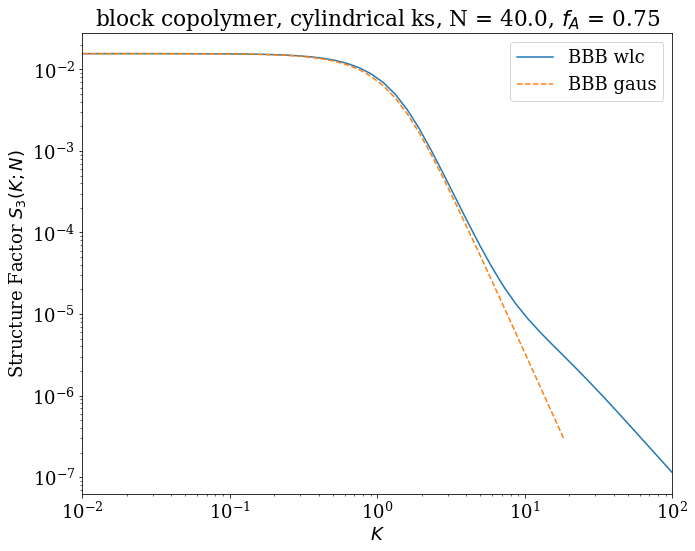

In [214]:
plt.figure(figsize=(10,8))
font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

# plt.plot(k_vec[:n], sf3_homo[:n], label = "homo", linestyle = "-")

# plt.plot(k_vec, sf3_stat, label = "wlcstat homo")



# plt.plot(k_vec[:], sf3_AAA_NEWEST[:], label = "AAA newest", linestyle = "-")

# plt.plot(k_vec[:], s3_arr_vert_AAA[:], label = "AAA wlc", linestyle = "-")

# plt.plot(k_vec[:], sf3_AAA_expanded[:], label = "AAA gaus", linestyle = "--")

# plt.plot(k_vec[:], s3_arr_vert_AAB[:], label = "AAB wlc", linestyle = "-")

# plt.plot(k_vec[:], sf3_AAB_expanded[:], label = "AAB gaus", linestyle = "--")

# plt.plot(k_vec[:], s3_arr_vert_ABB[:], label = "ABB wlc", linestyle = "-")

# plt.plot(k_vec[:], sf3_ABB_expanded[:], label = "ABB gaus", linestyle = "--")

plt.plot(k_vec[:], s3_arr_vert_BBB[:], label = "BBB wlc", linestyle = "-")

plt.plot(k_vec[:], sf3_BBB_expanded[:], label = "BBB gaus", linestyle = "--")




#


# plt.plot(k_vec[:], sf3_old[:], label = "AAA old")

# plt.plot(k_vec[:], sf3_AAB_slow[:], label = "AAB slow")

# plt.plot(k_vec[:n], sf3_AAB_fast[:n], label = "AAB fast", linestyle = "--")

# plt.plot(k_vec[:n], sf3_ABB_slow[:n], label = "ABB slow")

# plt.plot(k_vec[:n], sf3_ABB_fast[:n], label = "ABB fast", linestyle = "--")


plt.xscale('log')
plt.yscale('log')

plt.title("block copolymer, cylindrical ks, N = " + str(N) + ", $f_A$ = " + str(FA))
plt.xlabel(r'$K$')
plt.ylabel(r'Structure Factor $S_{3}(K;N)$')
plt.xlim((1e-2, 1e2))
plt.tight_layout()
plt.legend()
plt.show()

In [151]:
M = 4
poly_mat = np.array([0,0,0,1]) # each row is a polymer
dens = np.array([1])
N_m = 10.
b = 1.

M3_AAA = calc_monomer_matrix_3(poly_mat, dens)
M3_BAA_slow = calc_monomer_matrix_3_BAA(poly_mat, dens)
M3_BBA_slow = calc_monomer_matrix_3_BBA(poly_mat, dens)
M3_BBB_slow = calc_monomer_matrix_3_BBB(poly_mat, dens)

grid = np.indices((M,M,M))
j1 = grid[0]
j2 = grid[1]
j3 = grid[2]


M3_BAA = M3_AAA_j2j2j3 - M3_AAA

M3_BAA_fast = M3_AAA[j2, j2, j3] - M3_AAA
M3_BAA_slow == M3_BAA_fast

# M3_BBA_slow == M3_AAA-M3_AAA_j1j1j1 + M3_AAA_j3j2j3 +M3_AAA_j1j3j3
M3_BBA_fast = M3_AAA + M3_BAA_fast[j1, j3, j3] - M3_AAA[j2,j2,j3]
M3_BBA_slow == M3_BBA_fast

M3_BBB_fast = 1  - M3_AAA[j1, j1, j1] - M3_BAA_fast[j1, j2, j2] - M3_BAA_fast[j1, j3, j3] + M3_AAA[j2,j2,j3] - M3_AAA

# M3_BBB_slow == M3_BBB_fast

# M3_BAA_fast = M3_AAA[j2, j2, j3] - M3_AAA
# M3_BBA_fast = M3_AAA + M3_BAA_fast[j1, j3, j3] - M3_AAA[j2,j2,j3]
# M3_BBB_fast = 1  - M3_AAA[j1, j1, j1] - M3_BAA_fast[j1, j2, j2] - M3_BAA_fast[j1, j3, j3] + M3_AAA[j2,j2,j3] - M3_AAA

array([[[ True,  True,  True,  True],
        [ True,  True,  True,  True],
        [ True,  True,  True,  True],
        [ True,  True,  True,  True]],

       [[ True,  True,  True,  True],
        [ True,  True,  True,  True],
        [ True,  True,  True,  True],
        [ True,  True,  True,  True]],

       [[ True,  True,  True,  True],
        [ True,  True,  True,  True],
        [ True,  True,  True,  True],
        [ True,  True,  True,  True]],

       [[ True,  True,  True,  True],
        [ True,  True,  True,  True],
        [ True,  True,  True,  True],
        [ True,  True,  True,  True]]])

In [134]:
def calc_monomer_matrix_3_BBB(poly_mat, dens):
    # calculates the AAA monomer identity cross correlation matrix
    # assumes all polymers same length/ # of monomers, equal volume fraction of each
    
    # polymat - each row is a polymer
    # dens is an array where each entry is rel vol frac of correponding polymer
    if (np.sum(dens) != 1):
        raise Exception("polymer volumer fractions do not sum to one")
    if len(np.shape(poly_mat)) == 1: # single poly
        n_p = 1
        M = len(poly_mat)
        alph1 =np.ones(M)
        alph2 =np.ones(M)
        alph3 =np.ones(M)
        sig1 = 1*(poly_mat == alph1)
        sig2 = 1*(poly_mat == alph2)
        sig3 = 1*(poly_mat == alph3)
#         M2_AA = np.outer(sig1, sig2)
        M3_AAA = np.einsum('i,j,k',sig1,sig2,sig3)
        return M3_AAA
    
    n_p = poly_mat.shape[0]
    M = poly_mat.shape[1]
    alph1 =np.ones((n_p, M))
    alph2 =np.ones((n_p, M))
    alph3 =np.ones((n_p, M))

    
    #extend dens into n_pxM matrix
    poly_weights = (np.ones((n_p, M)).T * dens).T
    
    #multiply sigams by density of each polymer
    sigma1 = 1*((poly_mat == alph1))#.sum(axis = 0) #sigma. could multiply each
    sigma2 = 1*((poly_mat == alph2))#.sum(axis = 0)
    sigma3 = 1*((poly_mat == alph3))
    
    #need to do each row outer product with corresponding row, get n_p MxMxM matrices, then sum the results
    prods = np.einsum('bi,bo,bn->bion', sigma1*poly_weights, sigma2, sigma3) # performing row wise cross product (each poly contribution)
    M3_AAA = np.sum(prods, axis = 0)#           ^^^^ averaging each contribution
    return M3_AAA

In [79]:
def calc_monomer_matrix_3_BBA(poly_mat, dens):
    # calculates the AAA monomer identity cross correlation matrix
    # assumes all polymers same length/ # of monomers, equal volume fraction of each
    
    # polymat - each row is a polymer
    # dens is an array where each entry is rel vol frac of correponding polymer
    if (np.sum(dens) != 1):
        raise Exception("polymer volumer fractions do not sum to one")
    if len(np.shape(poly_mat)) == 1: # single poly
        n_p = 1
        M = len(poly_mat)
        alph1 =np.ones(M)
        alph2 =np.ones(M)
        alph3 =np.zeros(M)
        sig1 = 1*(poly_mat == alph1)
        sig2 = 1*(poly_mat == alph2)
        sig3 = 1*(poly_mat == alph3)
#         M2_AA = np.outer(sig1, sig2)
        M3_AAA = np.einsum('i,j,k',sig1,sig2,sig3)
        return M3_AAA
    
    n_p = poly_mat.shape[0]
    M = poly_mat.shape[1]
    alph1 =np.ones((n_p, M))
    alph2 =np.ones((n_p, M))
    alph3 =np.zeros((n_p, M))

    
    #extend dens into n_pxM matrix
    poly_weights = (np.ones((n_p, M)).T * dens).T
    
    #multiply sigams by density of each polymer
    sigma1 = 1*((poly_mat == alph1))#.sum(axis = 0) #sigma. could multiply each
    sigma2 = 1*((poly_mat == alph2))#.sum(axis = 0)
    sigma3 = 1*((poly_mat == alph3))
    
    #need to do each row outer product with corresponding row, get n_p MxMxM matrices, then sum the results
    prods = np.einsum('bi,bo,bn->bion', sigma1*poly_weights, sigma2, sigma3) # performing row wise cross product (each poly contribution)
    M3_AAA = np.sum(prods, axis = 0)#           ^^^^ averaging each contribution
    return M3_AAA

In [69]:
def calc_monomer_matrix_3_BAA(poly_mat, dens):
    # calculates the AAA monomer identity cross correlation matrix
    # assumes all polymers same length/ # of monomers, equal volume fraction of each
    
    # polymat - each row is a polymer
    # dens is an array where each entry is rel vol frac of correponding polymer
    if (np.sum(dens) != 1):
        raise Exception("polymer volumer fractions do not sum to one")
    if len(np.shape(poly_mat)) == 1: # single poly
        n_p = 1
        M = len(poly_mat)
        alph1 =np.ones(M)
        alph2 =np.zeros(M)
        alph3 =np.zeros(M)
        sig1 = 1*(poly_mat == alph1)
        sig2 = 1*(poly_mat == alph2)
        sig3 = 1*(poly_mat == alph3)
#         M2_AA = np.outer(sig1, sig2)
        M3_AAA = np.einsum('i,j,k',sig1,sig2,sig3)
        return M3_AAA
    
    n_p = poly_mat.shape[0]
    M = poly_mat.shape[1]
    alph1 =np.ones((n_p, M))
    alph2 =np.zeros((n_p, M))
    alph3 =np.zeros((n_p, M))

    
    #extend dens into n_pxM matrix
    poly_weights = (np.ones((n_p, M)).T * dens).T
    
    #multiply sigams by density of each polymer
    sigma1 = 1*((poly_mat == alph1))#.sum(axis = 0) #sigma. could multiply each
    sigma2 = 1*((poly_mat == alph2))#.sum(axis = 0)
    sigma3 = 1*((poly_mat == alph3))
    
    #need to do each row outer product with corresponding row, get n_p MxMxM matrices, then sum the results
    prods = np.einsum('bi,bo,bn->bion', sigma1*poly_weights, sigma2, sigma3) # performing row wise cross product (each poly contribution)
    M3_AAA = np.sum(prods, axis = 0)#           ^^^^ averaging each contribution
    return M3_AAA

In [ ]:
#TODO- ask about degeneracy done correctly, HOW TO VERIFY AAA????
#, figure out AAB
def calc_sf3_AAB_NEWEST(poly_mat, dens, N_m=1, b=1, k_vec = np.logspace(-2, 2, 50), k_vec_2 = np.logspace(-2, 2, 50)):
    M3_AAB = calc_monomer_matrix_3_BAA(poly_mat, dens)
    M = np.shape(M3_AAB)[0]
    nk = len(k_vec)

    one = np.ones((M,M,M))
    grid = np.indices((M,M,M))
    j1 = grid[0]
    j2 = grid[1]
    j3 = grid[2]
    
    S3_AAB_arr = np.zeros(nk)
    
    
    for i, k_1 in enumerate(k_vec):
        k_2 = k_vec_2[i]
        k_12 = k_1 + k_2
        
        # case 1 kA = k1 + k2, kB = k_1;   (assigning kA or kB doesnt matter)
        # case 2 kA = k2,      kB = k1 + k2; 
        # case 3 kA = k2,      kB = -k1
        
        k_cases = np.array([[k_1 + k_2, k_1], [k_2, k_1 + k_2], [k_2, -k_1]])
        
        # for each case and sub case, add to a matrix C(j1, j2, j3) which contains the contribution to the overall S3
        # then sum over all indices
        C = np.zeros((M,M,M))

        for kA, kB in k_cases:            
            xm_A = (1/6) * N_m * b**2 * np.linalg.norm(kA)**2 #k_1**2  #NOTE THIS XM is NEGATIVE
            xm_B = (1/6) * N_m * b**2 * np.linalg.norm(kB)**2

            #due to mathematica expontential integral issue, need to treat k_A == k_B separately
            cylindrical = False
            epsilon = 0.0000001
            if xm_A + epsilon > xm_B and xm_A - epsilon < xm_B:
                cylindrical = True

            # this math is for case 1; S3 > S2 > S1
            
            constant = np.exp(-xm_A*(j3 - j2)) * np.exp(-xm_B*(j2 - j1)) 
            
            # sub case 1; j3 > j2 > j1, {s1, s2, s3} any 
            index = (j3 > j2) * (j2 > j1)

            if cylindrical == True:
                integral = (1 / xm_A**2) * 2 * (-1 + np.cosh(xm_A))
            else:
                integral = (-2 / (xm_A * (xm_A - xm_B) * xm_B)) \
                * (-np.sinh(xm_A) + np.sinh(xm_A - xm_B) + np.sinh(xm_B))
            
            C[np.where(index != 0)] += M3_AAB[np.where(index != 0)] \
                                            * constant[np.where(index != 0)] \
                                            * integral \
                                            * 2 # degeneracy from switching js


            # sub case 2; j3 = j2 > j1, s3 > s2, {s1} any
            index = (j3 == j2) * (j2 > j1)

            if cylindrical == True:
                integral = (1 / xm_A**3) *( (2 + xm_A) * (-1 + np.cosh(xm_A)) - (xm_A * np.sinh(xm_A)) )
            else:
                integral = ((-1 + np.exp(xm_B))/(xm_A * (xm_A - xm_B)*xm_B**2)) \
                * (xm_A + (-1 + np.exp(-xm_A))*xm_B - xm_A*np.cosh(xm_B) + xm_A*np.sinh(xm_B))
            
            C[np.where(index != 0)] += M3_AAB[np.where(index != 0)] \
                                            * constant[np.where(index != 0)] \
                                            * integral \
                                            * 2 # degeneracy 

            # BONUS sub case 4; j3 > j2 = j1, s2 > s1, {s3} any 
            index = (j3 > j2) * (j2 == j1)

            if cylindrical == True:
                integral = (1 / xm_A**3) *( (2 + xm_A) * (-1 + np.cosh(xm_A)) - (xm_A * np.sinh(xm_A)) )
            else:
                integral = (((-1 + np.exp(xm_A))*(np.exp(-xm_A - xm_B)))/(xm_B * (xm_A - xm_B)*xm_A**2)) \
                * (-np.exp(xm_A)*xm_A + np.exp(xm_A + xm_B) * (xm_A -xm_B) + np.exp(xm_B)*xm_B)
            
            C[np.where(index != 0)] += M3_AAB[np.where(index != 0)] \
                                            * constant[np.where(index != 0)] \
                                            * integral \
                                            * 2 # degeneracy from swiching j2 j1, s2 s1

            # sub case 3; j3 = j2 = j1, s3 > s2 > s1
            index = (j3 == j2) * (j2 == j1)

            if cylindrical == True:
                integral = (1 / xm_A**3) * (np.exp(-xm_A) * (2 + np.exp(xm_A)*(-2 + xm_A) + xm_A))
            else:
                integral = (1 / (xm_A**2 * xm_B - xm_A * xm_B**2))\
                * ( xm_A + (((-1 + np.exp(-xm_B)) * xm_A)/(xm_B)) - xm_B + ((xm_B - np.exp(-xm_A)*xm_B)/(xm_A)) )

            C[np.where(index != 0)] += M3_AAB[np.where(index != 0)]\
                                            * constant[np.where(index != 0)]\
                                            * integral \
                                            * 2 
  
        S3_AAB_arr[i] += np.sum((1/M**3) * C)


    return S3_AAB_arr

# Old code

In [25]:
#TODO- ask about degeneracy done correctly
# expanded the k case for loop, hopefully do that [0001] = [1000] (before, these led to different strucutre factors)

# IMMEDIATE TO DO: make a S_AAB_slow using this expanded structure factor; see if now get same values for 0001 and 1000

def calc_sf3_exp(poly_mat, dens, N_m=1, b=1, k_vec = np.logspace(-2, 2, 50), k_vec_2 = np.logspace(-2, 2, 50)):
    M3_AAA = calc_monomer_matrix_3(poly_mat, dens)
    M = np.shape(M3_AAA)[0]
    nk = len(k_vec)

    one = np.ones((M,M,M))
    grid = np.indices((M,M,M))
    j1 = grid[0]
    j2 = grid[1]
    j3 = grid[2]
    
    S3_AAA_arr = np.zeros(nk)
    S3_AAB_arr_fast = np.zeros(nk)
    S3_ABB_arr_fast = np.zeros(nk)
    S3_BBB_arr_fast = np.zeros(nk)
    

    M3_BAA = M3_AAA[j2, j2, j3] - M3_AAA
    M3_BBA = M3_AAA + M3_BAA_fast[j1, j3, j3] - M3_AAA[j2,j2,j3]
    M3_BBB = 1  - M3_AAA[j1, j1, j1] - M3_BAA_fast[j1, j2, j2] - M3_BAA_fast[j1, j3, j3] + M3_AAA[j2,j2,j3] - M3_AAA

#     M3_BAA = calc_monomer_matrix_3_BAA(poly_mat, dens)


#     #gives MAAA (j1, j3, j3)  # NOT CORRECT!!!!!!!
#     init = [M3_AAA[j3 == j2].reshape((M, M))]
#     M3_AAA_j1j3j3 = init
#     for i in range(M-1):
#         M3_AAA_j1j3j3 = np.vstack((M3_AAA_j1j3j3, init))
    
    for i, k_1 in enumerate(k_vec):
        k_2 = k_vec_2[i]
        k_12 = k_1 + k_2
        
        # case 1 kA = k1 + k2, kB = k_1;   (assigning kA or kB doesnt matter)
        # case 2 kA = k2,      kB = k1 + k2; 
        # case 3 kA = k2,      kB = -k1
        
        k_cases = np.array([[k_1 + k_2, k_1], [k_2, k_1 + k_2], [k_2, -k_1]])
        
        # for each case and sub case, add to a matrix C(j1, j2, j3) which contains the contribution to the overall S3
        # then sum over all indices
        C = np.zeros((M,M,M))
        
        # for S3_AAB
        C2 = np.zeros((M,M,M))
        C9000 = np.zeros((M,M,M))
        Csad = np.zeros((M,M,M))
        
        # CASE 1; kA = k1 + k2, kB = k_1; S3 > S2 > S1
        kA, kB = k_cases[0]
        xm_A = (1/6) * N_m * b**2 * np.linalg.norm(kA)**2
        xm_B = (1/6) * N_m * b**2 * np.linalg.norm(kB)**2
        
        C, Csad = case1(C, Csad, poly_mat, dens, N_m, b, xm_A, xm_B, M, M3_AAA, M3_BAA)
        C, Csad = case1deg(C, Csad, poly_mat, dens, N_m, b, xm_A, xm_B, M, M3_AAA, M3_BAA)

        # CASE 2; kA = k2, kB = k1 + k2; S2 > S1 > S3
        
        kA, kB = k_cases[1]
        xm_A = (1/6) * N_m * b**2 * np.linalg.norm(kA)**2
        xm_B = (1/6) * N_m * b**2 * np.linalg.norm(kB)**2
        
        C, Csad = case2(C, Csad, poly_mat, dens, N_m, b, xm_A, xm_B, M, M3_AAA, M3_BAA)
        C, Csad = case2deg(C, Csad, poly_mat, dens, N_m, b, xm_A, xm_B, M, M3_AAA, M3_BAA)
        # CASE 3; kA = k2, kB = -k1; S2 > S3 > S1
        
        kA, kB = k_cases[2]
        xm_A = (1/6) * N_m * b**2 * np.linalg.norm(kA)**2
        xm_B = (1/6) * N_m * b**2 * np.linalg.norm(kB)**2
        
        C, Csad = case3(C, Csad, poly_mat, dens, N_m, b, xm_A, xm_B, M, M3_AAA, M3_BAA)
        C, Csad = case3deg(C, Csad, poly_mat, dens, N_m, b, xm_A, xm_B, M, M3_AAA, M3_BAA)

        S3_AAA_arr[i] += np.sum((1/M**3) * C)
#         S3_AAB_arr_fast[i] += np.sum((1/M**3) * C2) - S3_AAA_arr[i]
        
        S3_AAB_arr_fast[i] += np.sum((1/M**3) * Csad)       
    return S3_AAA_arr, S3_AAB_arr_fast

In [26]:
# S3 > S2 > S1
def case1(C, Csad, poly_mat, dens, N_m, b, xm_A, xm_B, M, M3_AAA, M3_BAA):
    
    grid = np.indices((M,M,M))
    j1 = grid[0]
    j2 = grid[1]
    j3 = grid[2]
    
    cylindrical = False
    epsilon = 0.0000001
    if xm_A + epsilon > xm_B and xm_A - epsilon < xm_B:
        cylindrical = True
    constant = np.exp(-xm_A*(j3 - j2)) * np.exp(-xm_B*(j2 - j1)) 

    # sub case 1; j3 > j2 > j1, {s1, s2, s3} any 
    index = (j3 > j2) * (j2 > j1)

    if cylindrical == True:
        integral = (1 / xm_A**2) * 2 * (-1 + np.cosh(xm_A))
    else:
        integral = (-2 / (xm_A * (xm_A - xm_B) * xm_B)) \
        * (-np.sinh(xm_A) + np.sinh(xm_A - xm_B) + np.sinh(xm_B))

    C[np.where(index != 0)] += M3_AAA[np.where(index != 0)] \
                                    * constant[np.where(index != 0)] \
                                    * integral \
                                    * 1 # degeneracy from switching js

    Csad[np.where(index != 0)] += M3_BAA[np.where(index != 0)] \
                                    * constant[np.where(index != 0)] \
                                    * integral \
                                    * 1 

    # sub case 2; j3 = j2 > j1, s3 > s2, {s1} any
    index = (j3 == j2) * (j2 > j1)

    if cylindrical == True:
        integral = (1 / xm_A**3) *( (2 + xm_A) * (-1 + np.cosh(xm_A)) - (xm_A * np.sinh(xm_A)) )
    else:
        integral = ((-1 + np.exp(xm_B))/(xm_A * (xm_A - xm_B)*xm_B**2)) \
        * (xm_A + (-1 + np.exp(-xm_A))*xm_B - xm_A*np.cosh(xm_B) + xm_A*np.sinh(xm_B))

    C[np.where(index != 0)] += M3_AAA[np.where(index != 0)] \
                                    * constant[np.where(index != 0)] \
                                    * integral \
                                    * 1 # degeneracy 

    Csad[np.where(index != 0)] += M3_BAA[np.where(index != 0)] \
                                    * constant[np.where(index != 0)] \
                                    * integral \
                                    * 1 

    # BONUS sub case 4; j3 > j2 = j1, s2 > s1, {s3} any 
    index = (j3 > j2) * (j2 == j1)

    if cylindrical == True:
        integral = (1 / xm_A**3) *( (2 + xm_A) * (-1 + np.cosh(xm_A)) - (xm_A * np.sinh(xm_A)) )
    else:
        integral = (((-1 + np.exp(xm_A))*(np.exp(-xm_A - xm_B)))/(xm_B * (xm_A - xm_B)*xm_A**2)) \
        * (-np.exp(xm_A)*xm_A + np.exp(xm_A + xm_B) * (xm_A -xm_B) + np.exp(xm_B)*xm_B)

    C[np.where(index != 0)] += M3_AAA[np.where(index != 0)] \
                                    * constant[np.where(index != 0)] \
                                    * integral \
                                    * 1 # degeneracy from swiching j2 j1, s2 s1

    Csad[np.where(index != 0)] += M3_BAA[np.where(index != 0)] \
                                    * constant[np.where(index != 0)] \
                                    * integral \
                                    * 1 

    # sub case 3; j3 = j2 = j1, s3 > s2 > s1
    index = (j3 == j2) * (j2 == j1)

    if cylindrical == True:
        integral = (1 / xm_A**3) * (np.exp(-xm_A) * (2 + np.exp(xm_A)*(-2 + xm_A) + xm_A))
    else:
        integral = (1 / (xm_A**2 * xm_B - xm_A * xm_B**2))\
        * ( xm_A + (((-1 + np.exp(-xm_B)) * xm_A)/(xm_B)) - xm_B + ((xm_B - np.exp(-xm_A)*xm_B)/(xm_A)) )

    C[np.where(index != 0)] += M3_AAA[np.where(index != 0)]\
                                    * constant[np.where(index != 0)]\
                                    * integral \
                                    * 1 
    Csad[np.where(index != 0)] += M3_BAA[np.where(index != 0)] \
                                    * constant[np.where(index != 0)] \
                                    * integral \
                                    * 1 
    return C, Csad

In [27]:
# S3 > S1 > S2
def case1deg(C, Csad, poly_mat, dens, N_m, b, xm_A, xm_B, M, M3_AAA, M3_BAA):
    
    grid = np.indices((M,M,M))
    j1 = grid[0]
    j2 = grid[1]
    j3 = grid[2]
    
    cylindrical = False
    epsilon = 0.0000001
    if xm_A + epsilon > xm_B and xm_A - epsilon < xm_B:
        cylindrical = True
    constant = np.exp(-xm_A*(j3 - j1)) * np.exp(-xm_B*(j1 - j2)) 

    # sub case 1; j3 > j2 > j1, {s1, s2, s3} any 
    index = (j3 > j1) * (j1 > j2)

    if cylindrical == True:
        integral = (1 / xm_A**2) * 2 * (-1 + np.cosh(xm_A))
    else:
        integral = (-2 / (xm_A * (xm_A - xm_B) * xm_B)) \
        * (-np.sinh(xm_A) + np.sinh(xm_A - xm_B) + np.sinh(xm_B))

    C[np.where(index != 0)] += M3_AAA[np.where(index != 0)] \
                                    * constant[np.where(index != 0)] \
                                    * integral \
                                    * 1 # degeneracy from switching js

    Csad[np.where(index != 0)] += M3_BAA[np.where(index != 0)] \
                                    * constant[np.where(index != 0)] \
                                    * integral \
                                    * 1 

    # sub case 2; j3 = j2 > j1, s3 > s2, {s1} any
    index = (j3 == j1) * (j1 > j2)

    if cylindrical == True:
        integral = (1 / xm_A**3) *( (2 + xm_A) * (-1 + np.cosh(xm_A)) - (xm_A * np.sinh(xm_A)) )
    else:
        integral = ((-1 + np.exp(xm_B))/(xm_A * (xm_A - xm_B)*xm_B**2)) \
        * (xm_A + (-1 + np.exp(-xm_A))*xm_B - xm_A*np.cosh(xm_B) + xm_A*np.sinh(xm_B))

    C[np.where(index != 0)] += M3_AAA[np.where(index != 0)] \
                                    * constant[np.where(index != 0)] \
                                    * integral \
                                    * 1 # degeneracy 

    Csad[np.where(index != 0)] += M3_BAA[np.where(index != 0)] \
                                    * constant[np.where(index != 0)] \
                                    * integral \
                                    * 1 

    # BONUS sub case 4; j3 > j2 = j1, s2 > s1, {s3} any 
    index = (j3 > j1) * (j1 == j2)

    if cylindrical == True:
        integral = (1 / xm_A**3) *( (2 + xm_A) * (-1 + np.cosh(xm_A)) - (xm_A * np.sinh(xm_A)) )
    else:
        integral = (((-1 + np.exp(xm_A))*(np.exp(-xm_A - xm_B)))/(xm_B * (xm_A - xm_B)*xm_A**2)) \
        * (-np.exp(xm_A)*xm_A + np.exp(xm_A + xm_B) * (xm_A -xm_B) + np.exp(xm_B)*xm_B)

    C[np.where(index != 0)] += M3_AAA[np.where(index != 0)] \
                                    * constant[np.where(index != 0)] \
                                    * integral \
                                    * 1 # degeneracy from swiching j2 j1, s2 s1

    Csad[np.where(index != 0)] += M3_BAA[np.where(index != 0)] \
                                    * constant[np.where(index != 0)] \
                                    * integral \
                                    * 1 

    # sub case 3; j3 = j2 = j1, s3 > s2 > s1
    index = (j3 == j1) * (j1 == j2)

    if cylindrical == True:
        integral = (1 / xm_A**3) * (np.exp(-xm_A) * (2 + np.exp(xm_A)*(-2 + xm_A) + xm_A))
    else:
        integral = (1 / (xm_A**2 * xm_B - xm_A * xm_B**2))\
        * ( xm_A + (((-1 + np.exp(-xm_B)) * xm_A)/(xm_B)) - xm_B + ((xm_B - np.exp(-xm_A)*xm_B)/(xm_A)) )

    C[np.where(index != 0)] += M3_AAA[np.where(index != 0)]\
                                    * constant[np.where(index != 0)]\
                                    * integral \
                                    * 1 
    Csad[np.where(index != 0)] += M3_BAA[np.where(index != 0)] \
                                    * constant[np.where(index != 0)] \
                                    * integral \
                                    * 1 
    return C, Csad

In [28]:
# kA = k2, kB = k1 + k2; S2 > S1 > S3
# case1 3>2>1
# 3 -> 2
# 2 -> 1
# 1 -> 3
def case2(C, Csad, poly_mat, dens, N_m, b, xm_A, xm_B, M, M3_AAA, M3_BAA):
    
    grid = np.indices((M,M,M))
    j1 = grid[0]
    j2 = grid[1]
    j3 = grid[2]
    
    cylindrical = False
    epsilon = 0.0000001
    if xm_A + epsilon > xm_B and xm_A - epsilon < xm_B:
        cylindrical = True
    constant = np.exp(-xm_A*(j2 - j1)) * np.exp(-xm_B*(j1 - j3)) 

    # sub case 1; j2 > j1 > j3, {s1, s2, s3} any 
    index = (j2 > j1) * (j1 > j3)

    if cylindrical == True:
        integral = (1 / xm_A**2) * 2 * (-1 + np.cosh(xm_A))
    else:
        integral = (-2 / (xm_A * (xm_A - xm_B) * xm_B)) \
        * (-np.sinh(xm_A) + np.sinh(xm_A - xm_B) + np.sinh(xm_B))

    C[np.where(index != 0)] += M3_AAA[np.where(index != 0)] \
                                    * constant[np.where(index != 0)] \
                                    * integral \
                                    * 1 # degeneracy from switching js

    Csad[np.where(index != 0)] += M3_BAA[np.where(index != 0)] \
                                    * constant[np.where(index != 0)] \
                                    * integral \
                                    * 1 

    # sub case 2; j2 = j1 > j3, s2 > s1, {s3} any
    index = (j2 == j1) * (j1 > j3)

    if cylindrical == True:
        integral = (1 / xm_A**3) *( (2 + xm_A) * (-1 + np.cosh(xm_A)) - (xm_A * np.sinh(xm_A)) )
    else:
        integral = ((-1 + np.exp(xm_B))/(xm_A * (xm_A - xm_B)*xm_B**2)) \
        * (xm_A + (-1 + np.exp(-xm_A))*xm_B - xm_A*np.cosh(xm_B) + xm_A*np.sinh(xm_B))

    C[np.where(index != 0)] += M3_AAA[np.where(index != 0)] \
                                    * constant[np.where(index != 0)] \
                                    * integral \
                                    * 1 # degeneracy 

    Csad[np.where(index != 0)] += M3_BAA[np.where(index != 0)] \
                                    * constant[np.where(index != 0)] \
                                    * integral \
                                    * 1 

    # BONUS sub case 4; j2 > j1 = j3, s1 > s3, {s2} any 
    index = (j2 > j1) * (j1 == j3)

    if cylindrical == True:
        integral = (1 / xm_A**3) *( (2 + xm_A) * (-1 + np.cosh(xm_A)) - (xm_A * np.sinh(xm_A)) )
    else:
        integral = (((-1 + np.exp(xm_A))*(np.exp(-xm_A - xm_B)))/(xm_B * (xm_A - xm_B)*xm_A**2)) \
        * (-np.exp(xm_A)*xm_A + np.exp(xm_A + xm_B) * (xm_A -xm_B) + np.exp(xm_B)*xm_B)

    C[np.where(index != 0)] += M3_AAA[np.where(index != 0)] \
                                    * constant[np.where(index != 0)] \
                                    * integral \
                                    * 1 # degeneracy from swiching j2 j1, s2 s1

    Csad[np.where(index != 0)] += M3_BAA[np.where(index != 0)] \
                                    * constant[np.where(index != 0)] \
                                    * integral \
                                    * 1 

    # sub case 3; j3 = j2 = j1, s2 > s1 > s3
    index = (j3 == j2) * (j2 == j1)

    if cylindrical == True:
        integral = (1 / xm_A**3) * (np.exp(-xm_A) * (2 + np.exp(xm_A)*(-2 + xm_A) + xm_A))
    else:
        integral = (1 / (xm_A**2 * xm_B - xm_A * xm_B**2))\
        * ( xm_A + (((-1 + np.exp(-xm_B)) * xm_A)/(xm_B)) - xm_B + ((xm_B - np.exp(-xm_A)*xm_B)/(xm_A)) )

    C[np.where(index != 0)] += M3_AAA[np.where(index != 0)]\
                                    * constant[np.where(index != 0)]\
                                    * integral \
                                    * 1 
    Csad[np.where(index != 0)] += M3_BAA[np.where(index != 0)] \
                                    * constant[np.where(index != 0)] \
                                    * integral \
                                    * 1 
    return C, Csad

In [29]:
# kA = k2, kB = k1 + k2; S1 > S2 > S3
# case1 3>2>1
# 3 -> 2
# 2 -> 1
# 1 -> 3
def case2deg(C, Csad, poly_mat, dens, N_m, b, xm_A, xm_B, M, M3_AAA, M3_BAA):
    
    grid = np.indices((M,M,M))
    j1 = grid[0]
    j2 = grid[1]
    j3 = grid[2]
    
    cylindrical = False
    epsilon = 0.0000001
    if xm_A + epsilon > xm_B and xm_A - epsilon < xm_B:
        cylindrical = True
    constant = np.exp(-xm_A*(j1 - j2)) * np.exp(-xm_B*(j2 - j3)) 

    # sub case 1; j2 > j1 > j3, {s1, s2, s3} any 
    index = (j1 > j2) * (j2 > j3)

    if cylindrical == True:
        integral = (1 / xm_A**2) * 2 * (-1 + np.cosh(xm_A))
    else:
        integral = (-2 / (xm_A * (xm_A - xm_B) * xm_B)) \
        * (-np.sinh(xm_A) + np.sinh(xm_A - xm_B) + np.sinh(xm_B))

    C[np.where(index != 0)] += M3_AAA[np.where(index != 0)] \
                                    * constant[np.where(index != 0)] \
                                    * integral \
                                    * 1 # degeneracy from switching js

    Csad[np.where(index != 0)] += M3_BAA[np.where(index != 0)] \
                                    * constant[np.where(index != 0)] \
                                    * integral \
                                    * 1 

    # sub case 2; j2 = j1 > j3, s2 > s1, {s3} any
    index = (j1 == j2) * (j2 > j3)

    if cylindrical == True:
        integral = (1 / xm_A**3) *( (2 + xm_A) * (-1 + np.cosh(xm_A)) - (xm_A * np.sinh(xm_A)) )
    else:
        integral = ((-1 + np.exp(xm_B))/(xm_A * (xm_A - xm_B)*xm_B**2)) \
        * (xm_A + (-1 + np.exp(-xm_A))*xm_B - xm_A*np.cosh(xm_B) + xm_A*np.sinh(xm_B))

    C[np.where(index != 0)] += M3_AAA[np.where(index != 0)] \
                                    * constant[np.where(index != 0)] \
                                    * integral \
                                    * 1 # degeneracy 

    Csad[np.where(index != 0)] += M3_BAA[np.where(index != 0)] \
                                    * constant[np.where(index != 0)] \
                                    * integral \
                                    * 1 

    # BONUS sub case 4; j2 > j1 = j3, s1 > s3, {s2} any 
    index = (j1 > j2) * (j2 == j3)

    if cylindrical == True:
        integral = (1 / xm_A**3) *( (2 + xm_A) * (-1 + np.cosh(xm_A)) - (xm_A * np.sinh(xm_A)) )
    else:
        integral = (((-1 + np.exp(xm_A))*(np.exp(-xm_A - xm_B)))/(xm_B * (xm_A - xm_B)*xm_A**2)) \
        * (-np.exp(xm_A)*xm_A + np.exp(xm_A + xm_B) * (xm_A -xm_B) + np.exp(xm_B)*xm_B)

    C[np.where(index != 0)] += M3_AAA[np.where(index != 0)] \
                                    * constant[np.where(index != 0)] \
                                    * integral \
                                    * 1 # degeneracy from swiching j2 j1, s2 s1

    Csad[np.where(index != 0)] += M3_BAA[np.where(index != 0)] \
                                    * constant[np.where(index != 0)] \
                                    * integral \
                                    * 1 

    # sub case 3; j3 = j2 = j1, s2 > s1 > s3
    index = (j3 == j2) * (j2 == j1)

    if cylindrical == True:
        integral = (1 / xm_A**3) * (np.exp(-xm_A) * (2 + np.exp(xm_A)*(-2 + xm_A) + xm_A))
    else:
        integral = (1 / (xm_A**2 * xm_B - xm_A * xm_B**2))\
        * ( xm_A + (((-1 + np.exp(-xm_B)) * xm_A)/(xm_B)) - xm_B + ((xm_B - np.exp(-xm_A)*xm_B)/(xm_A)) )

    C[np.where(index != 0)] += M3_AAA[np.where(index != 0)]\
                                    * constant[np.where(index != 0)]\
                                    * integral \
                                    * 1 
    Csad[np.where(index != 0)] += M3_BAA[np.where(index != 0)] \
                                    * constant[np.where(index != 0)] \
                                    * integral \
                                    * 1 
    return C, Csad

In [30]:
#  S2 > S3 > S1

# 3 -> 1
# 1 -> 3
def case3(C, Csad, poly_mat, dens, N_m, b, xm_A, xm_B, M, M3_AAA, M3_BAA):
    
    grid = np.indices((M,M,M))
    j1 = grid[0]
    j2 = grid[1]
    j3 = grid[2]
    
    cylindrical = False
    epsilon = 0.0000001
    if xm_A + epsilon > xm_B and xm_A - epsilon < xm_B:
        cylindrical = True
    constant = np.exp(-xm_A*(j2 - j3)) * np.exp(-xm_B*(j3 - j1)) 

    # sub case 1; j2 > j3 > j1, {s1, s2, s3} any 
    index = (j2 > j3) * (j3 > j1)

    if cylindrical == True:
        integral = (1 / xm_A**2) * 2 * (-1 + np.cosh(xm_A))
    else:
        integral = (-2 / (xm_A * (xm_A - xm_B) * xm_B)) \
        * (-np.sinh(xm_A) + np.sinh(xm_A - xm_B) + np.sinh(xm_B))

    C[np.where(index != 0)] += M3_AAA[np.where(index != 0)] \
                                    * constant[np.where(index != 0)] \
                                    * integral \
                                    * 1 # degeneracy from switching js

    Csad[np.where(index != 0)] += M3_BAA[np.where(index != 0)] \
                                    * constant[np.where(index != 0)] \
                                    * integral \
                                    * 1 

    # sub case 2; j2 = j3 > j1, s2 > s3, {s1} any
    index = (j2 == j3) * (j3 > j1)

    if cylindrical == True:
        integral = (1 / xm_A**3) *( (2 + xm_A) * (-1 + np.cosh(xm_A)) - (xm_A * np.sinh(xm_A)) )
    else:
        integral = ((-1 + np.exp(xm_B))/(xm_A * (xm_A - xm_B)*xm_B**2)) \
        * (xm_A + (-1 + np.exp(-xm_A))*xm_B - xm_A*np.cosh(xm_B) + xm_A*np.sinh(xm_B))

    C[np.where(index != 0)] += M3_AAA[np.where(index != 0)] \
                                    * constant[np.where(index != 0)] \
                                    * integral \
                                    * 1 # degeneracy 
    
    Csad[np.where(index != 0)] += M3_BAA[np.where(index != 0)] \
                                    * constant[np.where(index != 0)] \
                                    * integral \
                                    * 1 

    # BONUS sub case 4; j2 > j3 = j1, s3 > s1, {s2} any 
    index = (j2 > j3) * (j3 == j1)

    if cylindrical == True:
        integral = (1 / xm_A**3) *( (2 + xm_A) * (-1 + np.cosh(xm_A)) - (xm_A * np.sinh(xm_A)) )
    else:
        integral = (((-1 + np.exp(xm_A))*(np.exp(-xm_A - xm_B)))/(xm_B * (xm_A - xm_B)*xm_A**2)) \
        * (-np.exp(xm_A)*xm_A + np.exp(xm_A + xm_B) * (xm_A -xm_B) + np.exp(xm_B)*xm_B)
    
    C[np.where(index != 0)] += M3_AAA[np.where(index != 0)] \
                                    * constant[np.where(index != 0)] \
                                    * integral \
                                    * 1 # degeneracy from swiching j2 j1, s2 s1

    Csad[np.where(index != 0)] += M3_BAA[np.where(index != 0)] \
                                    * constant[np.where(index != 0)] \
                                    * integral \
                                    * 1 

    # sub case 3; j3 = j2 = j1, s2 > s3 > s1
    index = (j3 == j2) * (j2 == j1)

    if cylindrical == True:
        integral = (1 / xm_A**3) * (np.exp(-xm_A) * (2 + np.exp(xm_A)*(-2 + xm_A) + xm_A))
    else:
        integral = (1 / (xm_A**2 * xm_B - xm_A * xm_B**2))\
        * ( xm_A + (((-1 + np.exp(-xm_B)) * xm_A)/(xm_B)) - xm_B + ((xm_B - np.exp(-xm_A)*xm_B)/(xm_A)) )

    C[np.where(index != 0)] += M3_AAA[np.where(index != 0)]\
                                    * constant[np.where(index != 0)]\
                                    * integral \
                                    * 1 
    Csad[np.where(index != 0)] += M3_BAA[np.where(index != 0)] \
                                    * constant[np.where(index != 0)] \
                                    * integral \
                                    * 1 
    return C, Csad

In [31]:
#  S1 > S3 > S2
def case3deg(C, Csad, poly_mat, dens, N_m, b, xm_A, xm_B, M, M3_AAA, M3_BAA):
    
    grid = np.indices((M,M,M))
    j1 = grid[0]
    j2 = grid[1]
    j3 = grid[2]
    
    cylindrical = False
    epsilon = 0.0000001
    if xm_A + epsilon > xm_B and xm_A - epsilon < xm_B:
        cylindrical = True
    constant = np.exp(-xm_A*(j1 - j3)) * np.exp(-xm_B*(j3 - j2)) 

    # sub case 1; j2 > j3 > j1, {s1, s2, s3} any 
    index = (j1 > j3) * (j3 > j2)

    if cylindrical == True:
        integral = (1 / xm_A**2) * 2 * (-1 + np.cosh(xm_A))
    else:
        integral = (-2 / (xm_A * (xm_A - xm_B) * xm_B)) \
        * (-np.sinh(xm_A) + np.sinh(xm_A - xm_B) + np.sinh(xm_B))

    C[np.where(index != 0)] += M3_AAA[np.where(index != 0)] \
                                    * constant[np.where(index != 0)] \
                                    * integral \
                                    * 1 # degeneracy from switching js

    Csad[np.where(index != 0)] += M3_BAA[np.where(index != 0)] \
                                    * constant[np.where(index != 0)] \
                                    * integral \
                                    * 1 

    # sub case 2; j2 = j3 > j1, s2 > s3, {s1} any
    index = (j1 == j3) * (j3 > j2)

    if cylindrical == True:
        integral = (1 / xm_A**3) *( (2 + xm_A) * (-1 + np.cosh(xm_A)) - (xm_A * np.sinh(xm_A)) )
    else:
        integral = ((-1 + np.exp(xm_B))/(xm_A * (xm_A - xm_B)*xm_B**2)) \
        * (xm_A + (-1 + np.exp(-xm_A))*xm_B - xm_A*np.cosh(xm_B) + xm_A*np.sinh(xm_B))

    C[np.where(index != 0)] += M3_AAA[np.where(index != 0)] \
                                    * constant[np.where(index != 0)] \
                                    * integral \
                                    * 1 # degeneracy 
    
    Csad[np.where(index != 0)] += M3_BAA[np.where(index != 0)] \
                                    * constant[np.where(index != 0)] \
                                    * integral \
                                    * 1 

    # BONUS sub case 4; j2 > j3 = j1, s3 > s1, {s2} any 
    index = (j1 > j3) * (j3 == j2)

    if cylindrical == True:
        integral = (1 / xm_A**3) *( (2 + xm_A) * (-1 + np.cosh(xm_A)) - (xm_A * np.sinh(xm_A)) )
    else:
        integral = (((-1 + np.exp(xm_A))*(np.exp(-xm_A - xm_B)))/(xm_B * (xm_A - xm_B)*xm_A**2)) \
        * (-np.exp(xm_A)*xm_A + np.exp(xm_A + xm_B) * (xm_A -xm_B) + np.exp(xm_B)*xm_B)
    
    C[np.where(index != 0)] += M3_AAA[np.where(index != 0)] \
                                    * constant[np.where(index != 0)] \
                                    * integral \
                                    * 1 # degeneracy from swiching j2 j1, s2 s1

    Csad[np.where(index != 0)] += M3_BAA[np.where(index != 0)] \
                                    * constant[np.where(index != 0)] \
                                    * integral \
                                    * 1 

    # sub case 3; j3 = j2 = j1, s2 > s3 > s1
    index = (j3 == j1) * (j1 == j2)

    if cylindrical == True:
        integral = (1 / xm_A**3) * (np.exp(-xm_A) * (2 + np.exp(xm_A)*(-2 + xm_A) + xm_A))
    else:
        integral = (1 / (xm_A**2 * xm_B - xm_A * xm_B**2))\
        * ( xm_A + (((-1 + np.exp(-xm_B)) * xm_A)/(xm_B)) - xm_B + ((xm_B - np.exp(-xm_A)*xm_B)/(xm_A)) )

    C[np.where(index != 0)] += M3_AAA[np.where(index != 0)]\
                                    * constant[np.where(index != 0)]\
                                    * integral \
                                    * 1 
    Csad[np.where(index != 0)] += M3_BAA[np.where(index != 0)] \
                                    * constant[np.where(index != 0)] \
                                    * integral \
                                    * 1 
    return C, Csad

In [ ]:
# CLEANED up version of AAA calc for individual meeting
def calc_sf3(poly_mat, dens, N_m=1, b=1, k_vec = np.logspace(-2, 2, 50), k_vec_2 = np.logspace(-2, 2, 50)):
    M3_AAA = calc_monomer_matrix_3(poly_mat, dens)
    M = np.shape(M3_AAA)[0]
    nk = len(k_vec)

    one = np.ones((M,M,M))
    grid = np.indices((M,M,M))
    j1 = grid[0]
    j2 = grid[1]
    j3 = grid[2]
    
    S3_AAA_arr = np.zeros(nk)
    
    for i, k_1 in enumerate(k_vec):
        k_2 = k_vec_2[i]
        k_12 = k_1 + k_2
        
        # case 1 kA = k1 + k2, kB = k_1;   (assigning kA or kB doesnt matter)
        # case 2 kA = k2,      kB = k1 + k2; 
        # case 3 kA = k2,      kB = -k1
        
        k_cases = np.array([[k_1 + k_2, k_1], [k_2, k_1 + k_2], [k_2, -k_1]])
        
        # for each case and sub case, add to the s3 the contribution to the overall S3 for each index

        for kA, kB in k_cases:            
            xm_A = (1/6) * N_m * b**2 * np.linalg.norm(kA)**2 #k_1**2  #NOTE THIS XM is NEGATIVE
            xm_B = (1/6) * N_m * b**2 * np.linalg.norm(kB)**2

            #due to mathematica expontential integral issue, need to treat k_A == k_B separately
            cylindrical = False
            epsilon = 0.0000001
            if xm_A + epsilon > xm_B and xm_A - epsilon < xm_B:
                cylindrical = True

            # this math is for case 1; S3 > S2 > S1
            
            constant = np.exp(-xm_A*(j3 - j2)) * np.exp(-xm_B*(j2 - j1)) 
            
            # sub case 1; j3 > j2 > j1, {s1, s2, s3} any 
            index = (j3 > j2) * (j2 > j1)

            if cylindrical == True:
                integral = (1 / xm_A**2) * 2 * (-1 + np.cosh(xm_A))
            else:
                integral = (-2 / (xm_A * (xm_A - xm_B) * xm_B)) \
                * (-np.sinh(xm_A) + np.sinh(xm_A - xm_B) + np.sinh(xm_B))
            
            S3_AAA_arr[i] += np.sum((2/M**3)*M3_AAA[np.where(index != 0)] \
                                            * constant[np.where(index != 0)] \
                                            * integral)
            # sub case 2; j3 = j2 > j1, s3 > s2, {s1} any
            index = (j3 == j2) * (j2 > j1)

            if cylindrical == True:
                integral = (1 / xm_A**3) *( (2 + xm_A) * (-1 + np.cosh(xm_A)) - (xm_A * np.sinh(xm_A)) )
            else:
                integral = ((-1 + np.exp(xm_B))/(xm_A * (xm_A - xm_B)*xm_B**2)) \
                * (xm_A + (-1 + np.exp(-xm_A))*xm_B - xm_A*np.cosh(xm_B) + xm_A*np.sinh(xm_B))
            
 
            S3_AAA_arr[i] += np.sum((2/M**3)*M3_AAA[np.where(index != 0)] \
                                            * constant[np.where(index != 0)] \
                                            * integral)
            # BONUS sub case 4; j3 > j2 = j1, s2 > s1, {s3} any 
            index = (j3 > j2) * (j2 == j1)

            if cylindrical == True:
                integral = (1 / xm_A**3) *( (2 + xm_A) * (-1 + np.cosh(xm_A)) - (xm_A * np.sinh(xm_A)) )
            else:
                integral = (((-1 + np.exp(xm_A))*(np.exp(-xm_A - xm_B)))/(xm_B * (xm_A - xm_B)*xm_A**2)) \
                * (-np.exp(xm_A)*xm_A + np.exp(xm_A + xm_B) * (xm_A -xm_B) + np.exp(xm_B)*xm_B)
        
            S3_AAA_arr[i] += np.sum((2/M**3)*M3_AAA[np.where(index != 0)] \
                                            * constant[np.where(index != 0)] \
                                            * integral)
            # sub case 3; j3 = j2 = j1, s3 > s2 > s1
            index = (j3 == j2) * (j2 == j1)

            if cylindrical == True:
                integral = (1 / xm_A**3) * (np.exp(-xm_A) * (2 + np.exp(xm_A)*(-2 + xm_A) + xm_A))
            else:
                integral = (1 / (xm_A**2 * xm_B - xm_A * xm_B**2))\
                * ( xm_A + (((-1 + np.exp(-xm_B)) * xm_A)/(xm_B)) - xm_B + ((xm_B - np.exp(-xm_A)*xm_B)/(xm_A)) )
            
            S3_AAA_arr[i] += np.sum((2/M**3)*M3_AAA[np.where(index != 0)] \
                                            * constant[np.where(index != 0)] \
                                            * integral)

    return S3_AAA_arr

In [ ]:
def calc_sf3_NEWEST_AAB(poly_mat, dens, N_m=1, b=1, k_vec = np.logspace(-2, 2, 50), k_vec_2 = np.logspace(-2, 2, 50)):
    M3_AAA = calc_monomer_matrix_3_AAB(poly_mat, dens)
    M = np.shape(M3_AAA)[0]
    nk = len(k_vec)

    one = np.ones((M,M,M))
    grid = np.indices((M,M,M))
    j1 = grid[0]
    j2 = grid[1]
    j3 = grid[2]
    
    S3_AAA_arr = np.zeros(nk)
    
    for i, k_1 in enumerate(k_vec):
        k_2 = k_vec_2[i]
        k_12 = k_1 + k_2
        
        # case 1 kA = k1 + k2, kB = k_1;   (assigning kA or kB doesnt matter)
        # case 2 kA = k2,      kB = k1 + k2; 
        # case 3 kA = k2,      kB = -k1
        
        k_cases = np.array([[k_1 + k_2, k_1], [k_2, k_1 + k_2], [k_2, -k_1]])
        
        # for each case and sub case, add to a matrix C(j1, j2, j3) which contains the contribution to the overall S3
        # then sum over all indices
        C = np.zeros((M,M,M))
        
        for kA, kB in k_cases:            
            xm_A = (1/6) * N_m * b**2 * np.linalg.norm(kA)**2 #k_1**2  #NOTE THIS XM is NEGATIVE
            xm_B = (1/6) * N_m * b**2 * np.linalg.norm(kB)**2

            #due to mathematica expontential integral issue, need to treat k_A == k_B separately
            cylindrical = False
            epsilon = 0.0000001
            if xm_A + epsilon > xm_B and xm_A - epsilon < xm_B:
                cylindrical = True

            # this math is for case 1; S3 > S2 > S1
            
            constant = np.exp(-xm_A*(j3 - j2)) * np.exp(-xm_B*(j2 - j1)) 
            
            # sub case 1; j3 > j2 > j1, {s1, s2, s3} any 
            index = (j3 > j2) * (j2 > j1)

            if cylindrical == True:
                integral = (1 / xm_A**2) * 2 * (-1 + np.cosh(xm_A))
            else:
                integral = (-2 / (xm_A * (xm_A - xm_B) * xm_B)) \
                * (-np.sinh(xm_A) + np.sinh(xm_A - xm_B) + np.sinh(xm_B))
            
            C[np.where(index != 0)] += M3_AAA[np.where(index != 0)] \
                                            * constant[np.where(index != 0)] \
                                            * integral \
                                            * 2 # degeneract formswitching js


            # sub case 2; j3 = j2 > j1, s3 > s2, {s1} any
            index = (j3 == j2) * (j2 > j1)

            if cylindrical == True:
                integral = (1 / xm_A**3) *( (2 + xm_A) * (-1 + np.cosh(xm_A)) - (xm_A * np.sinh(xm_A)) )
            else:
                integral = ((-1 + np.exp(xm_B))/(xm_A * (xm_A - xm_B)*xm_B**2)) \
                * (xm_A + (-1 + np.exp(-xm_A))*xm_B - xm_A*np.cosh(xm_B) + xm_A*np.sinh(xm_B))
            
            C[np.where(index != 0)] += M3_AAA[np.where(index != 0)] \
                                            * constant[np.where(index != 0)] \
                                            * integral \
                                            * 4 # degeneracy from swiching j2 j1, s2 s1

            
            # sub case 3; j3 = j2 = j1, s3 > s2 > s1
            index = (j3 == j2) * (j2 == j1)

            if cylindrical == True:
                integral = (1 / xm_A**3) * (np.exp(-xm_A) * (2 + np.exp(xm_A)*(-2 + xm_A) + xm_A))
            else:
                integral = (1 / (xm_A**2 * xm_B - xm_A * xm_B**2))\
                * ( xm_A + (((-1 + np.exp(-xm_B)) * xm_A)/(xm_B)) - xm_B + ((xm_B - np.exp(-xm_A)*xm_B)/(xm_A)) )
            
            C[np.where(index != 0)] += M3_AAA[np.where(index != 0)]\
                                            * constant[np.where(index != 0)]\
                                            * integral \
                                            * 2

        S3_AAA_arr[i] += np.sum((1/M**3) * C)

    return S3_AAA_arr#, S3_AAB_arr_fast

In [ ]:
M3_AAA = calc_monomer_matrix_3(poly_mat, dens)
grid = np.indices((M,M,M))
j1 = grid[0]
j2 = grid[1]
j3 = grid[2]
#gives MAAA (j2, j2, j3)
init = [M3_AAA[j1 == j2].reshape((M, M))]
M3_AAA_j2j2j3 = init
for i in range(M-1):
    M3_AAA_j2j2j3 = np.vstack((M3_AAA_j2j2j3, init))

#gives MAAA (j1, j3, j3)
init = [M3_AAA[j3 == j2].reshape((M, M))]
M3_AAA_j1j3j3 = init
for i in range(M-1):
    M3_AAA_j1j3j3 = np.vstack((M3_AAA_j1j3j3, init))
    
#gives MAAA (j1, j2, j1)
init = [M3_AAA[j3 == j1].reshape((M, M))]
M3_AAA_j1j2j1 = init
for i in range(M-1):
    M3_AAA_j1j2j1 = np.vstack((M3_AAA_j1j2j1, init))
M3_AAA_j2j2j3

In [ ]:
#TODO- ask about degeneracy done correctly, extend to SAAB, ABB, BBB
def calc_sf3_NEWER(poly_mat, dens, N_m=1, b=1, k_vec = np.logspace(-2, 2, 50), k_vec_2 = np.logspace(-2, 2, 50)):
    M3_AAA = calc_monomer_matrix_3(poly_mat, dens)
    M = np.shape(M3_AAA)[0]
    nk = len(k_vec)

    one = np.ones((M,M,M))
    grid = np.indices((M,M,M))
    j1 = grid[0]
    j2 = grid[1]
    j3 = grid[2]
    
    S3_AAA_arr = np.zeros(nk)
    S3_AAB_arr_fast = np.zeros(nk)
    S3_ABB_arr_fast = np.zeros(nk)
    S3_BBB_arr_fast = np.zeros(nk)
    
    S3_AAA_arr_alt = np.zeros(nk)
    #gives MAAA (j2, j2, j3)
    init = [M3_AAA[j1 == j2].reshape((M, M))]
    M3_AAA_j2j2j3 = init
    for i in range(M-1):
        M3_AAA_j2j2j3 = np.vstack((M3_AAA_j2j2j3, init))
    
    for i, k_1 in enumerate(k_vec):
        k_2 = k_vec_2[i]
        k_12 = k_1 + k_2
        
        # case 1 kA = k1 + k2, kB = k_1;   (assigning kA or kB doesnt matter)
        # case 2 kA = k2,      kB = k1 + k2; 
        # case 3 kA = k2,      kB = -k1
        
        k_cases = np.array([[k_1 + k_2, k_1], [k_2, k_1 + k_2], [k_2, -k_1]])
        
        for kA, kB in k_cases:            
            xm_A = (1/6) * N_m * b**2 * np.linalg.norm(kA)**2 #k_1**2  #NOTE THIS XM is NEGATIVE
            xm_B = (1/6) * N_m * b**2 * np.linalg.norm(kB)**2

            #due to mathematica expontential integral issue, need to treat k_A == k_B separately
            cylindrical = False
            epsilon = 0.0000001
            if xm_A + epsilon > xm_B and xm_A - epsilon < xm_B:
                cylindrical = True

            # this math is for case 1; S3 > S2 > S1
            
            constant = np.exp(-xm_A*(j3 - j2)) * np.exp(-xm_B*(j2 - j1)) 
            
            # for each sub case, generate a matrix C(j1, j2, j3) which contains the contribution to the overall S3
            # then sum over all indices
            
            # sub case 1; j3 > j2 > j1, {s1, s2, s3} any
            C = np.zeros((M,M,M))
            alt_C = np.zeros((M,M,M)) 
            index = (j3 > j2) * (j2 > j1)

            if cylindrical == True:
                integral = (1 / xm_A**2) * 2 * (-1 + np.cosh(xm_A))
            else:
                integral = (-2 / (xm_A * (xm_A - xm_B) * xm_B)) \
                * (-np.sinh(xm_A) + np.sinh(xm_A - xm_B) + np.sinh(xm_B))

            C[np.where(index != 0)] += M3_AAA[np.where(index != 0)]  
            C[np.where(index != 0)] *= constant[np.where(index != 0)]
            C *= integral
            C *= 2 # degeneracy from switching js
            
            alt_C[np.where(index != 0)] += M3_AAA[np.where(index != 0)] * constant[np.where(index != 0)] * integral * 2

            S3_AAA_arr[i] += np.sum((1/M**3) * C)
            
#             raw_1 = np.sum((1/M**3) * C)
#             print("first contribution raw", np.sum((1/M**3) * C))

            # sub case 2; j3 = j2 > j1, s3 > s2, {s1} any
            C = np.zeros((M,M,M))
            index = (j3 == j2) * (j2 > j1)

            if cylindrical == True:
                integral = (1 / xm_A**3) *( (2 + xm_A) * (-1 + np.cosh(xm_A)) - (xm_A * np.sinh(xm_A)) )
            else:
                integral = ((-1 + np.exp(xm_B))/(xm_A * (xm_A - xm_B)*xm_B**2)) \
                * (xm_A + (-1 + np.exp(-xm_A))*xm_B - xm_A*np.cosh(xm_B) + xm_A*np.sinh(xm_B))

            C[np.where(index != 0)] += M3_AAA[np.where(index != 0)]  
            C[np.where(index != 0)] *= constant[np.where(index != 0)]
            C *= integral
            C *= 4 #degeneracy from swiching j2 j1, s2 s1
            
            alt_C[np.where(index != 0)] += M3_AAA[np.where(index != 0)] * constant[np.where(index != 0)] * integral * 4

            S3_AAA_arr[i] += np.sum((1/M**3) * C)
#             raw_2 = np.sum((1/M**3) * C)
#             print("second contribution raw", np.sum((1/M**3) * C))



            # sub case 3; j3 = j2 = j1, s3 > s2 > s1
            C = np.zeros((M,M,M))
            index = (j3 == j2) * (j2 == j1)

            if cylindrical == True:
                integral = (1 / xm_A**3) * (np.exp(-xm_A) * (2 + np.exp(xm_A)*(-2 + xm_A) + xm_A))
            else:
                integral = (1 / (xm_A**2 * xm_B - xm_A * xm_B**2))\
                * ( xm_A + (((-1 + np.exp(-xm_B)) * xm_A)/(xm_B)) - xm_B + ((xm_B - np.exp(-xm_A)*xm_B)/(xm_A)) )

            C[np.where(index != 0)] += M3_AAA[np.where(index != 0)]  
            C[np.where(index != 0)] *= constant[np.where(index != 0)]
            C *= integral
            C *= 2
            
            alt_C[np.where(index != 0)] += M3_AAA[np.where(index != 0)] * constant[np.where(index != 0)] * integral * 2
            
            S3_AAA_arr[i] += np.sum((1/M**3) * C)
            
            S3_AAA_arr_alt[i] += np.sum((1/M**3) * alt_C)

#             S3_AAB_arr_fast[i] = np.sum((1/M**3) * C * M3_AAA_j2j2j3) - S3_AAA_arr[i]

#             raw_3 = np.sum((1/M**3) * C)
#             print("third contribution raw", np.sum((1/M**3) * C))
            
#             print("S3_AAA_arr raw is first plus second plus third")
#             print("S3_AAA_ times two in cons", S3_AAA_arr[i])
#             print("S3_AAA_ before times two at end", S3_AAA_arr[i])
#             print("S3_AAA times two at end only", 2*(raw_1+raw_2+raw_3) )
            
#         S3_AAA_arr[i] *= 2 #degeneracy for capital S cases - each has two
#         print("S3_AAA_ after times two at end", S3_AAA_arr[i])
#         print(S3_AAA_arr[i]==S3_AAA_arr_alt[i])
#         print("old:", S3_AAA_arr[i])
#         print("alt:", S3_AAA_arr_alt[i])
    return S3_AAA_arr

In [ ]:
# from sf2, found that the exploding integrals at high k should be compensated by cons that go to 0. find where that doesnt happen
def calc_sf3(poly_mat, dens, N_m=1, b=1, k_vec = np.logspace(-2, 2, 50), k_vec_2 = np.logspace(-2, 2, 50)):
    #calculates all variations of the S(3) AAA AAB ABB BBB for a range of k
    M3_AAA = calc_monomer_matrix_3(poly_mat, dens)
    M = np.shape(M3_AAA)[0]
    nk = len(k_vec)

    one = np.ones((M,M,M))
    grid = np.indices((M,M,M))
    j1 = grid[0]
    j2 = grid[1]
    j3 = grid[2]
    
    S3_AAA_arr = np.zeros(nk)
    S3_AAB_arr_fast = np.zeros(nk)
    S3_ABB_arr_fast = np.zeros(nk)
    S3_BBB_arr_fast = np.zeros(nk)
    
    #gives MAAA (j2, j2, j3)
    init = [M3_AAA[j1 == j2].reshape((M, M))]
    M3_AAA_j2j2j3 = init
    for i in range(M-1):
        M3_AAA_j2j2j3 = np.vstack((M3_AAA_j2j2j3, init))
        
    #gives MAAA (j1, j3, j3)
    init = [M3_AAA[j2 == j3].reshape((M, M))]
    M3_AAA_j1j3j3 = init
    for i in range(M-1):
        M3_AAA_j1j3j3 = np.vstack((M3_AAA_j1j3j3, init))
        
    #gives MAAA (j3, j2, j3)
    init = [M3_AAA[j1 == j3].reshape((M, M))]
    M3_AAA_j2j3j3 = init
    for i in range(M-1):
        M3_AAA_j2j3j3 = np.vstack((M3_AAA_j2j3j3, init))
        
    #gives MAAA (j3, j3, j3)
    init = [M3_AAA[(j1 == j3) * (j2 == j3)]]
    M3_AAA_j3j3j3 = init
    for i in range(M-1):
        M3_AAA_j3j3j3 = np.vstack((M3_AAA_j3j3j3, init))
#     H_AA = np.diag(M2_AA)
#     H_AA_mat = (H_AA * one).T


# Structure- combine all integrals and constants into one MxMxM matrix, which you then multiply by the 
#           monomer cross correlation matrix, then sum over each index to get s3AAA
    
    for i, k_1 in enumerate(k_vec):
        k_2 = k_vec_2[i]
        kA = k_1
        kB = k_1 + k_2
#         kA = np.linalg.norm(k_1)
#         kB = np.linalg.norm(k_1 + k_2)**2
        
#         print("mag k_A =", np.linalg.norm(kA))
#         print("mag k_B =", np.linalg.norm(kB))
#         print("^^THESE ARE EQUAL FOR CYLINDRICAL symmetry")

        C = np.zeros((M, M, M))
        xm_1 = -(1/6) * N_m * b**2 * np.linalg.norm(kA)**2 #k_1**2  #NOTE THIS XM is NEGATIVE
        xm_2 = -(1/6) * N_m * b**2 * np.linalg.norm(kB)**2 #k_2**2
        
#         print("xm1: ", xm_1)
#         print("xm2: ", xm_2)
                     
        
        epsilon = 0.0000001

        if xm_1 + epsilon > xm_2 and xm_1 - epsilon < xm_2:
#             true for cylindrical case
#             means xm1 == xm2, so (xm1 - xm2) = 0
#             do calculations where only one variable integrated over (replace xm2 with xm1)
#            (due to mathematica issues w integral { exp([xm1 - xm2] * x) = exp(0 * x)} )
            
    
            # j1 = j2 = j3 (homopolymer case)

                # 1; s2 > s3 > s1
            diag1 = (1 / xm_1**3) * (2 + np.exp(xm_1) * (-2 + xm_1) + xm_1)
                # 2; s3 > s1, s3 > s2
            diag2 = (1 / xm_1**3) * (1 + xm_1 + np.exp(xm_1) * (-2 + np.cosh(xm_1)))
                # 3; s2 < s3, s1 > s3
            diag3 = diag2
                # 4; s3 > s2, s1 > s2
            diag4 = diag1
            np.fill_diagonal(C, np.diagonal(one * (diag1 + diag2 + diag3 + diag4)))
            

            # j1 > (j2 = j3)   
            indxs = (j1 > j2) * (j2 == j3)
            
            # 5
            frac = (1/xm_1**3)
            AA = 0.5 * (np.exp(-xm_1) * (-1 + np.exp(xm_1))**3)
            BB = np.exp(-xm_1) * (-1 + np.exp(xm_1))
            CC = 1 + np.exp(xm_1) * (-1 + xm_1)
            
            intgrl =  frac * (AA + BB*CC)
            cons = np.exp(xm_1*(j1-j3))

            rplcr = indxs * (intgrl * cons)
            C[np.where(rplcr != 0)] = rplcr[np.where(rplcr != 0)]  

            
            # j2 > (j1 = j3)
            indxs = (j2 > j1) * (j1 == j3)
            
#             intgrl =  same as above!
            cons = np.exp(xm_1*(j2-j3))

            rplcr = indxs * (intgrl * cons)
            C[np.where(rplcr != 0)] = rplcr[np.where(rplcr != 0)]  


            # j1 < (j2 = j3)
            indxs = (j1 < j2) * (j2 == j3)
            
            # 6
            frac = (1/xm_1**3)
            AA = 0.5*(np.exp(-xm_1) * (-1 + np.exp(xm_1))**3)
            BB = (-2 + xm_1)*(-1 + np.cosh(xm_1))
            CC = xm_1 * np.sinh(xm_1)
            intgrl = frac * (AA + BB + CC)
            
            cons = np.exp(xm_1*(j3-j1))
            
            rplcr = indxs * (intgrl * cons)
            C[np.where(rplcr != 0)] = rplcr[np.where(rplcr != 0)]  


            # j2 < (j1 = j3)
            indxs = (j2 < j1) * (j1 == j3)
            
#             intgrl =  same as above!
            cons = np.exp(xm_1*(j3-j2))

            rplcr = indxs * (intgrl * cons)
            C[np.where(rplcr != 0)] = rplcr[np.where(rplcr != 0)]  
            
            
            # j3 > (j2 = j1)
            indxs = (j3 > j1) * (j1 == j2)
            
            #7
            intgrl =  (-2 * np.sinh(xm_1) + np.sinh(2 * xm_1))/ xm_1**3
            cons = np.exp(xm_1*(j3-j2))*np.exp(xm_1*(j3-j1))

            rplcr = indxs * (intgrl * cons)
            C[np.where(rplcr != 0)] = rplcr[np.where(rplcr != 0)]  
            
            
            # j3 < (j2 = j1)
            indxs = (j3 < j1) * (j1 == j2)
            
            
#             intgrl =  same as above!
            cons = np.exp(xm_1*(j2-j3))*np.exp(xm_1*(j1-j3))

            rplcr = indxs * (intgrl * cons)
            C[np.where(rplcr != 0)] = rplcr[np.where(rplcr != 0)]  
            
            
            # j1 > j2 > j3
            indxs = (j1 > j2) * (j2 > j3)
            
            
#             intgrl =  same as above!
#             cons = same as above!

            rplcr = indxs * (intgrl * cons)
            C[np.where(rplcr != 0)] = rplcr[np.where(rplcr != 0)]  
            
            
            # j2 > j1 > j3
            indxs = (j1 > j2) * (j2 > j3)
            
            
#             intgrl =  same as above!
#             cons = same as above

            rplcr = indxs * (intgrl * cons)
            C[np.where(rplcr != 0)] = rplcr[np.where(rplcr != 0)]  
            
            
            # j3 > j2 > j1
            indxs = (j3 > j2) * (j2 > j1)
            
            
#             intgrl =  same as above!
            cons = np.exp(xm_1*(j3-j1))*np.exp(xm_1*(j3-j2))

            rplcr = indxs * (intgrl * cons)
            C[np.where(rplcr != 0)] = rplcr[np.where(rplcr != 0)]  
            
            
            # j3 > j1 > j2
            indxs = (j3 > j1) * (j1 > j2)
            
            
#             intgrl =  same as above!
#             cons = same as above!

            rplcr = indxs * (intgrl * cons)
            C[np.where(rplcr != 0)] = rplcr[np.where(rplcr != 0)]  
            
            
            # j1 > j3 > j2
            indxs = (j1 > j3) * (j3 > j2)
            
            
            intgrl = (2 * (-1 + np.cosh(xm_1))) / xm_1 **2
            cons = np.exp(xm_1*(j1-j3))*np.exp(xm_1*(j3-j2))

            rplcr = indxs * (intgrl * cons)
            C[np.where(rplcr != 0)] = rplcr[np.where(rplcr != 0)]  
            
            
            # j2 > j3 > j1
            indxs = (j2 > j3) * (j3 > j1)
            
            
#             intgrl = (same as above!
            cons = np.exp(xm_1*(j3-j1))*np.exp(xm_1*(j2-j3))

            rplcr = indxs * (intgrl * cons)
            C[np.where(rplcr != 0)] = rplcr[np.where(rplcr != 0)]  
            
#             print("C = ", C)
            S3_AAA_arr[i] = np.sum((1/M**3) * C * M3_AAA)
            S3_AAB_arr_fast[i] = np.sum((1/M**3) * C * M3_AAA_j2j2j3) - S3_AAA_arr[i]
            S3_ABB_arr_fast[i] = S3_AAA_arr[i] + np.sum((1/M**3) * C * M3_AAA_j3j3j3) \
            - np.sum((1/M**3) * C * M3_AAA_j2j3j3) - np.sum((1/M**3) * C * M3_AAA_j1j3j3)

        else:
            raise Exception("k1 and k2 are not cylindrical- need to implement")
            # mathematica integrals where xm_1 != xm_2
            # j1 = j2 = j3
                # 1; s2 > s3 > s1
            diag1 = (1 / (xm_1**2 * xm_2 - xm_1 * xm_2**2)) * \
            (xm_1 + ((xm_1 - np.exp(xm_2)*xm_1)/(xm_2)) - xm_2 + (((-1 + np.exp(xm_1))*xm_2)/(xm_1)))
            
                # 2; s3 > s1, s3 > s2
            
            frac = 1 / (xm_1**2 * xm_2**2 * (xm_1 + xm_2))
            A = -1*((-1 + np.exp(xm_1)) * xm_2**2) 
            B = xm_1**2 * (1 - np.exp(xm_2) + xm_2)
            CC = xm_1 * xm_2 * (1 - np.exp(xm_1) - np.exp(xm_2) + np.exp(xm_1 + xm_2) + xm_2)
            diag2 = frac * (A + B + CC)
            
                # 3; s2 < s3, s1 > s3
            diag3 = diag2
                
                # 4; s3 > s2, s1 > s2
            frac = -1 / (xm_1 + xm_2)
            A = (1 - np.exp(xm_1))/ xm_1**2
            B = 1 / xm_1
            CC = (-1 + np.exp(-xm_2) + xm_2)/(xm_2**2)
            
            diag4 = frac * (A + B + CC )

            np.fill_diagonal(C, np.diagonal(one * (diag1 + diag2 + diag3 + diag4)))
            
            print(C)
            
#           DO ALL OTHER j CASES for non-cyl
#         




    return (S3_AAA_arr, S3_AAB_arr_fast, S3_ABB_arr_fast)

In [ ]:
# from sf2, found that the exploding integrals at high k should be compensated by cons that go to 0. find where that doesnt happen
def calc_sf3_ABB(poly_mat, dens, N_m=1, b=1, k_vec = np.logspace(-2, 2, 50), k_vec_2 = np.logspace(-2, 2, 50)):
    #calculates all variations of the S(3) AAA AAB ABB BBB for a range of k
    M3_AAA = calc_monomer_matrix_3_BBA(poly_mat, dens)
    M = np.shape(M3_AAA)[0]
    nk = len(k_vec)

    one = np.ones((M,M,M))
    grid = np.indices((M,M,M))
    j1 = grid[0]
    j2 = grid[1]
    j3 = grid[2]
    
    S3_AAA_arr = np.zeros(nk)



# Structure- combine all integrals and constants into one MxMxM matrix, which you then multiply by the 
#           monomer cross correlation matrix, then sum over each index to get s3AAA
    
    for i, k_1 in enumerate(k_vec):
        k_2 = k_vec_2[i]
        kA = k_1
        kB = k_1 + k_2
#         kA = np.linalg.norm(k_1)
#         kB = np.linalg.norm(k_1 + k_2)**2
        
#         print("mag k_A =", np.linalg.norm(kA))
#         print("mag k_B =", np.linalg.norm(kB))
#         print("^^THESE ARE EQUAL FOR CYLINDRICAL symmetry")

        C = np.zeros((M, M, M))
        xm_1 = -(1/6) * N_m * b**2 * np.linalg.norm(kA)**2 #k_1**2  #NOTE THIS XM is NEGATIVE
        xm_2 = -(1/6) * N_m * b**2 * np.linalg.norm(kB)**2 #k_2**2
        
#         print("xm1: ", xm_1)
#         print("xm2: ", xm_2)
                     
        
        epsilon = 0.0000001

        if xm_1 + epsilon > xm_2 and xm_1 - epsilon < xm_2:
#             true for cylindrical case
#             means xm1 == xm2, so (xm1 - xm2) = 0
#             do calculations where only one variable integrated over (replace xm2 with xm1)
#            (due to mathematica issues w integral { exp([xm1 - xm2] * x) = exp(0 * x)} )
            
    
            # j1 = j2 = j3

                # 1; s2 > s3 > s1
            diag1 = (1 / xm_1**3) * (2 + np.exp(xm_1) * (-2 + xm_1) + xm_1)
                # 2; s3 > s1, s3 > s2
            diag2 = (1 / xm_1**3) * (1 + xm_1 + np.exp(xm_1) * (-2 + np.cosh(xm_1)))
                # 3; s2 < s3, s1 > s3
            diag3 = diag2
                # 4; s3 > s2, s1 > s2
            diag4 = diag1
            np.fill_diagonal(C, np.diagonal(one * (diag1 + diag2 + diag3 + diag4)))
            

            # j1 > (j2 = j3)   
            indxs = (j1 > j2) * (j2 == j3)
            
            # 5
            frac = (1/xm_1**3)
            AA = 0.5 * (np.exp(-xm_1) * (-1 + np.exp(xm_1))**3)
            BB = np.exp(-xm_1) * (-1 + np.exp(xm_1))
            CC = 1 + np.exp(xm_1) * (-1 + xm_1)
            
            intgrl =  frac * (AA + BB*CC)
            cons = np.exp(xm_1*(j1-j3))

            rplcr = indxs * (intgrl * cons)
            C[np.where(rplcr != 0)] = rplcr[np.where(rplcr != 0)]  

            
            # j2 > (j1 = j3)
            indxs = (j2 > j1) * (j1 == j3)
            
#             intgrl =  same as above!
            cons = np.exp(xm_1*(j2-j3))

            rplcr = indxs * (intgrl * cons)
            C[np.where(rplcr != 0)] = rplcr[np.where(rplcr != 0)]  


            # j1 < (j2 = j3)
            indxs = (j1 < j2) * (j2 == j3)
            
            # 6
            frac = (1/xm_1**3)
            AA = 0.5*(np.exp(-xm_1) * (-1 + np.exp(xm_1))**3)
            BB = (-2 + xm_1)*(-1 + np.cosh(xm_1))
            CC = xm_1 * np.sinh(xm_1)
            intgrl = frac * (AA + BB + CC)
            
            cons = np.exp(xm_1*(j3-j1))
            
            rplcr = indxs * (intgrl * cons)
            C[np.where(rplcr != 0)] = rplcr[np.where(rplcr != 0)]  


            # j2 < (j1 = j3)
            indxs = (j2 < j1) * (j1 == j3)
            
#             intgrl =  same as above!
            cons = np.exp(xm_1*(j3-j2))

            rplcr = indxs * (intgrl * cons)
            C[np.where(rplcr != 0)] = rplcr[np.where(rplcr != 0)]  
            
            
            # j3 > (j2 = j1)
            indxs = (j3 > j1) * (j1 == j2)
            
            #7
            intgrl =  (-2 * np.sinh(xm_1) + np.sinh(2 * xm_1))/ xm_1**3
            cons = np.exp(xm_1*(j3-j2))*np.exp(xm_1*(j3-j1))

            rplcr = indxs * (intgrl * cons)
            C[np.where(rplcr != 0)] = rplcr[np.where(rplcr != 0)]  
            
            
            # j3 < (j2 = j1)
            indxs = (j3 < j1) * (j1 == j2)
            
            
#             intgrl =  same as above!
            cons = np.exp(xm_1*(j2-j3))*np.exp(xm_1*(j1-j3))

            rplcr = indxs * (intgrl * cons)
            C[np.where(rplcr != 0)] = rplcr[np.where(rplcr != 0)]  
            
            
            # j1 > j2 > j3
            indxs = (j1 > j2) * (j2 > j3)
            
            
#             intgrl =  same as above!
#             cons = same as above!

            rplcr = indxs * (intgrl * cons)
            C[np.where(rplcr != 0)] = rplcr[np.where(rplcr != 0)]  
            
            
            # j2 > j1 > j3
            indxs = (j1 > j2) * (j2 > j3)
            
            
#             intgrl =  same as above!
#             cons = same as above

            rplcr = indxs * (intgrl * cons)
            C[np.where(rplcr != 0)] = rplcr[np.where(rplcr != 0)]  
            
            
            # j3 > j2 > j1
            indxs = (j3 > j2) * (j2 > j1)
            
            
#             intgrl =  same as above!
            cons = np.exp(xm_1*(j3-j1))*np.exp(xm_1*(j3-j2))

            rplcr = indxs * (intgrl * cons)
            C[np.where(rplcr != 0)] = rplcr[np.where(rplcr != 0)]  
            
            
            # j3 > j1 > j2
            indxs = (j3 > j1) * (j1 > j2)
            
            
#             intgrl =  same as above!
#             cons = same as above!

            rplcr = indxs * (intgrl * cons)
            C[np.where(rplcr != 0)] = rplcr[np.where(rplcr != 0)]  
            
            
            # j1 > j3 > j2
            indxs = (j1 > j3) * (j3 > j2)
            
            
            intgrl = (2 * (-1 + np.cosh(xm_1))) / xm_1 **2
            cons = np.exp(xm_1*(j1-j3))*np.exp(xm_1*(j3-j2))

            rplcr = indxs * (intgrl * cons)
            C[np.where(rplcr != 0)] = rplcr[np.where(rplcr != 0)]  
            
            
            # j2 > j3 > j1
            indxs = (j2 > j3) * (j3 > j1)
            
            
#             intgrl = (same as above!
            cons = np.exp(xm_1*(j3-j1))*np.exp(xm_1*(j2-j3))

            rplcr = indxs * (intgrl * cons)
            C[np.where(rplcr != 0)] = rplcr[np.where(rplcr != 0)]  
            
#             print("C = ", C)
            S3_AAA_arr[i] = np.sum((1/M**3) * C * M3_AAA)
            
        else:
            raise Exception("k1 and k2 are not cylindrical- need to implement")
            # mathematica integrals where xm_1 != xm_2
            # j1 = j2 = j3
                # 1; s2 > s3 > s1
            diag1 = (1 / (xm_1**2 * xm_2 - xm_1 * xm_2**2)) * \
            (xm_1 + ((xm_1 - np.exp(xm_2)*xm_1)/(xm_2)) - xm_2 + (((-1 + np.exp(xm_1))*xm_2)/(xm_1)))
            
                # 2; s3 > s1, s3 > s2
            
            frac = 1 / (xm_1**2 * xm_2**2 * (xm_1 + xm_2))
            A = -1*((-1 + np.exp(xm_1)) * xm_2**2) 
            B = xm_1**2 * (1 - np.exp(xm_2) + xm_2)
            CC = xm_1 * xm_2 * (1 - np.exp(xm_1) - np.exp(xm_2) + np.exp(xm_1 + xm_2) + xm_2)
            diag2 = frac * (A + B + CC)
            
                # 3; s2 < s3, s1 > s3
            diag3 = diag2
                
                # 4; s3 > s2, s1 > s2
            frac = -1 / (xm_1 + xm_2)
            A = (1 - np.exp(xm_1))/ xm_1**2
            B = 1 / xm_1
            CC = (-1 + np.exp(-xm_2) + xm_2)/(xm_2**2)
            
            diag4 = frac * (A + B + CC )

            np.fill_diagonal(C, np.diagonal(one * (diag1 + diag2 + diag3 + diag4)))
            
            print(C)
            
#           DO ALL OTHER j CASES for non-cyl
#         




    return (S3_AAA_arr)#, S2_AB_arr_fast, S2_BB_arr_fast)

In [ ]:
def calc_monomer_matrix_3_BBA(poly_mat, dens):
    # calculates the AAA monomer identity cross correlation matrix
    # assumes all polymers same length/ # of monomers, equal volume fraction of each
    
    # polymat - each row is a polymer
    # dens is an array where each entry is rel vol frac of correponding polymer
    if (np.sum(dens) != 1):
        raise Exception("polymer volumer fractions do not sum to one")
    if len(np.shape(poly_mat)) == 1: # single poly
        n_p = 1
        M = len(poly_mat)
        #i think correct
        alph1 =np.ones(M)
        alph2 =np.ones(M)
        alph3 =np.zeros(M)
        
        
        sig1 = 1*(poly_mat == alph1)
        sig2 = 1*(poly_mat == alph2)
        sig3 = 1*(poly_mat == alph3)
#         M2_AA = np.outer(sig1, sig2)
        M3_AAA = np.einsum('i,j,k',sig1,sig2,sig3)
        return M3_AAA
    
    n_p = poly_mat.shape[0]
    M = poly_mat.shape[1]
    alph1 =np.ones((n_p, M))
    alph2 =np.ones((n_p, M))
    alph3 =np.zeros((n_p, M))

    
    #extend dens into n_pxM matrix
    poly_weights = (np.ones((n_p, M)).T * dens).T
    
    #multiply sigams by density of each polymer
    sigma1 = 1*((poly_mat == alph1))#.sum(axis = 0) #sigma. could multiply each
    sigma2 = 1*((poly_mat == alph2))#.sum(axis = 0)
    sigma3 = 1*((poly_mat == alph3))
    
    #need to do each row outer product with corresponding row, get n_p MxMxM matrices, then sum the results
    prods = np.einsum('bi,bo,bn->bion', sigma1*poly_weights, sigma2, sigma3) # performing row wise cross product (each poly contribution)
    M3_AAA = np.sum(prods, axis = 0)#           ^^^^ averaging each contribution
    return M3_AAA

In [ ]:
def calc_monomer_matrix_3_BAA(poly_mat, dens):
    # calculates the AAA monomer identity cross correlation matrix
    # assumes all polymers same length/ # of monomers, equal volume fraction of each
    
    # polymat - each row is a polymer
    # dens is an array where each entry is rel vol frac of correponding polymer
    if (np.sum(dens) != 1):
        raise Exception("polymer volumer fractions do not sum to one")
    if len(np.shape(poly_mat)) == 1: # single poly
        n_p = 1
        M = len(poly_mat)
        alph1 =np.ones(M)
        alph2 =np.zeros(M)
        alph3 =np.zeros(M)
        sig1 = 1*(poly_mat == alph1)
        sig2 = 1*(poly_mat == alph2)
        sig3 = 1*(poly_mat == alph3)
#         M2_AA = np.outer(sig1, sig2)
        M3_AAA = np.einsum('i,j,k',sig1,sig2,sig3)
        return M3_AAA
    
    n_p = poly_mat.shape[0]
    M = poly_mat.shape[1]
    alph1 =np.ones((n_p, M))
    alph2 =np.zeros((n_p, M))
    alph3 =np.zeros((n_p, M))

    
    #extend dens into n_pxM matrix
    poly_weights = (np.ones((n_p, M)).T * dens).T
    
    #multiply sigams by density of each polymer
    sigma1 = 1*((poly_mat == alph1))#.sum(axis = 0) #sigma. could multiply each
    sigma2 = 1*((poly_mat == alph2))#.sum(axis = 0)
    sigma3 = 1*((poly_mat == alph3))
    
    #need to do each row outer product with corresponding row, get n_p MxMxM matrices, then sum the results
    prods = np.einsum('bi,bo,bn->bion', sigma1*poly_weights, sigma2, sigma3) # performing row wise cross product (each poly contribution)
    M3_AAA = np.sum(prods, axis = 0)#           ^^^^ averaging each contribution
    return M3_AAA

In [ ]:
# from sf2, found that the exploding integrals at high k should be compensated by cons that go to 0. find where that doesnt happen
def calc_sf3_AAB(poly_mat, dens, N_m=1, b=1, k_vec = np.logspace(-2, 2, 50), k_vec_2 = np.logspace(-2, 2, 50)):
    #calculates all variations of the S(3) AAA AAB ABB BBB for a range of k
    M3_AAA = calc_monomer_matrix_3_BAA(poly_mat, dens)
    M = np.shape(M3_AAA)[0]
    nk = len(k_vec)

    one = np.ones((M,M,M))
    grid = np.indices((M,M,M))
    j1 = grid[0]
    j2 = grid[1]
    j3 = grid[2]
    
    S3_AAA_arr = np.zeros(nk)



# Structure- combine all integrals and constants into one MxMxM matrix, which you then multiply by the 
#           monomer cross correlation matrix, then sum over each index to get s3AAA
    
    for i, k_1 in enumerate(k_vec):
        k_2 = k_vec_2[i]
        kA = k_1
        kB = k_1 + k_2
#         kA = np.linalg.norm(k_1)
#         kB = np.linalg.norm(k_1 + k_2)**2
        
#         print("mag k_A =", np.linalg.norm(kA))
#         print("mag k_B =", np.linalg.norm(kB))
#         print("^^THESE ARE EQUAL FOR CYLINDRICAL symmetry")

        C = np.zeros((M, M, M))
        xm_1 = -(1/6) * N_m * b**2 * np.linalg.norm(kA)**2 #k_1**2  #NOTE THIS XM is NEGATIVE
        xm_2 = -(1/6) * N_m * b**2 * np.linalg.norm(kB)**2 #k_2**2
        
#         print("xm1: ", xm_1)
#         print("xm2: ", xm_2)
                     
        
        epsilon = 0.0000001

        if xm_1 + epsilon > xm_2 and xm_1 - epsilon < xm_2:
#             true for cylindrical case
#             means xm1 == xm2, so (xm1 - xm2) = 0
#             do calculations where only one variable integrated over (replace xm2 with xm1)
#            (due to mathematica issues w integral { exp([xm1 - xm2] * x) = exp(0 * x)} )
            
    
            # j1 = j2 = j3

                # 1; s2 > s3 > s1
            diag1 = (1 / xm_1**3) * (2 + np.exp(xm_1) * (-2 + xm_1) + xm_1)
                # 2; s3 > s1, s3 > s2
            diag2 = (1 / xm_1**3) * (1 + xm_1 + np.exp(xm_1) * (-2 + np.cosh(xm_1)))
                # 3; s2 < s3, s1 > s3
            diag3 = diag2
                # 4; s3 > s2, s1 > s2
            diag4 = diag1
            np.fill_diagonal(C, np.diagonal(one * (diag1 + diag2 + diag3 + diag4)))
            

            # j1 > (j2 = j3)   
            indxs = (j1 > j2) * (j2 == j3)
            
            # 5
            frac = (1/xm_1**3)
            AA = 0.5 * (np.exp(-xm_1) * (-1 + np.exp(xm_1))**3)
            BB = np.exp(-xm_1) * (-1 + np.exp(xm_1))
            CC = 1 + np.exp(xm_1) * (-1 + xm_1)
            
            intgrl =  frac * (AA + BB*CC)
            cons = np.exp(xm_1*(j1-j3))

            rplcr = indxs * (intgrl * cons)
            C[np.where(rplcr != 0)] = rplcr[np.where(rplcr != 0)]  

            
            # j2 > (j1 = j3)
            indxs = (j2 > j1) * (j1 == j3)
            
#             intgrl =  same as above!
            cons = np.exp(xm_1*(j2-j3))

            rplcr = indxs * (intgrl * cons)
            C[np.where(rplcr != 0)] = rplcr[np.where(rplcr != 0)]  


            # j1 < (j2 = j3)
            indxs = (j1 < j2) * (j2 == j3)
            
            # 6
            frac = (1/xm_1**3)
            AA = 0.5*(np.exp(-xm_1) * (-1 + np.exp(xm_1))**3)
            BB = (-2 + xm_1)*(-1 + np.cosh(xm_1))
            CC = xm_1 * np.sinh(xm_1)
            intgrl = frac * (AA + BB + CC)
            
            cons = np.exp(xm_1*(j3-j1))
            
            rplcr = indxs * (intgrl * cons)
            C[np.where(rplcr != 0)] = rplcr[np.where(rplcr != 0)]  


            # j2 < (j1 = j3)
            indxs = (j2 < j1) * (j1 == j3)
            
#             intgrl =  same as above!
            cons = np.exp(xm_1*(j3-j2))

            rplcr = indxs * (intgrl * cons)
            C[np.where(rplcr != 0)] = rplcr[np.where(rplcr != 0)]  
            
            
            # j3 > (j2 = j1)
            indxs = (j3 > j1) * (j1 == j2)
            
            #7
            intgrl =  (-2 * np.sinh(xm_1) + np.sinh(2 * xm_1))/ xm_1**3
            cons = np.exp(xm_1*(j3-j2))*np.exp(xm_1*(j3-j1))

            rplcr = indxs * (intgrl * cons)
            C[np.where(rplcr != 0)] = rplcr[np.where(rplcr != 0)]  
            
            
            # j3 < (j2 = j1)
            indxs = (j3 < j1) * (j1 == j2)
            
            
#             intgrl =  same as above!
            cons = np.exp(xm_1*(j2-j3))*np.exp(xm_1*(j1-j3))

            rplcr = indxs * (intgrl * cons)
            C[np.where(rplcr != 0)] = rplcr[np.where(rplcr != 0)]  
            
            
            # j1 > j2 > j3
            indxs = (j1 > j2) * (j2 > j3)
            
            
#             intgrl =  same as above!
#             cons = same as above!

            rplcr = indxs * (intgrl * cons)
            C[np.where(rplcr != 0)] = rplcr[np.where(rplcr != 0)]  
            
            
            # j2 > j1 > j3
            indxs = (j1 > j2) * (j2 > j3)
            
            
#             intgrl =  same as above!
#             cons = same as above

            rplcr = indxs * (intgrl * cons)
            C[np.where(rplcr != 0)] = rplcr[np.where(rplcr != 0)]  
            
            
            # j3 > j2 > j1
            indxs = (j3 > j2) * (j2 > j1)
            
            
#             intgrl =  same as above!
            cons = np.exp(xm_1*(j3-j1))*np.exp(xm_1*(j3-j2))

            rplcr = indxs * (intgrl * cons)
            C[np.where(rplcr != 0)] = rplcr[np.where(rplcr != 0)]  
            
            
            # j3 > j1 > j2
            indxs = (j3 > j1) * (j1 > j2)
            
            
#             intgrl =  same as above!
#             cons = same as above!

            rplcr = indxs * (intgrl * cons)
            C[np.where(rplcr != 0)] = rplcr[np.where(rplcr != 0)]  
            
            
            # j1 > j3 > j2
            indxs = (j1 > j3) * (j3 > j2)
            
            
            intgrl = (2 * (-1 + np.cosh(xm_1))) / xm_1 **2
            cons = np.exp(xm_1*(j1-j3))*np.exp(xm_1*(j3-j2))

            rplcr = indxs * (intgrl * cons)
            C[np.where(rplcr != 0)] = rplcr[np.where(rplcr != 0)]  
            
            
            # j2 > j3 > j1
            indxs = (j2 > j3) * (j3 > j1)
            
            
#             intgrl = (same as above!
            cons = np.exp(xm_1*(j3-j1))*np.exp(xm_1*(j2-j3))

            rplcr = indxs * (intgrl * cons)
            C[np.where(rplcr != 0)] = rplcr[np.where(rplcr != 0)]  
            
#             print("C = ", C)
            S3_AAA_arr[i] = np.sum((1/M**3) * C * M3_AAA)
            
        else:
            raise Exception("k1 and k2 are not cylindrical- need to implement")
            # mathematica integrals where xm_1 != xm_2
            # j1 = j2 = j3
                # 1; s2 > s3 > s1
            diag1 = (1 / (xm_1**2 * xm_2 - xm_1 * xm_2**2)) * \
            (xm_1 + ((xm_1 - np.exp(xm_2)*xm_1)/(xm_2)) - xm_2 + (((-1 + np.exp(xm_1))*xm_2)/(xm_1)))
            
                # 2; s3 > s1, s3 > s2
            
            frac = 1 / (xm_1**2 * xm_2**2 * (xm_1 + xm_2))
            A = -1*((-1 + np.exp(xm_1)) * xm_2**2) 
            B = xm_1**2 * (1 - np.exp(xm_2) + xm_2)
            CC = xm_1 * xm_2 * (1 - np.exp(xm_1) - np.exp(xm_2) + np.exp(xm_1 + xm_2) + xm_2)
            diag2 = frac * (A + B + CC)
            
                # 3; s2 < s3, s1 > s3
            diag3 = diag2
                
                # 4; s3 > s2, s1 > s2
            frac = -1 / (xm_1 + xm_2)
            A = (1 - np.exp(xm_1))/ xm_1**2
            B = 1 / xm_1
            CC = (-1 + np.exp(-xm_2) + xm_2)/(xm_2**2)
            
            diag4 = frac * (A + B + CC )

            np.fill_diagonal(C, np.diagonal(one * (diag1 + diag2 + diag3 + diag4)))
            
            print(C)
            
#           DO ALL OTHER j CASES for non-cyl
#         




    return (S3_AAA_arr)#, S2_AB_arr_fast, S2_BB_arr_fast)

In [ ]:
goal = np.array([[[1, 2],
          [7, 8]],
         [[1, 2],
          [7, 8]]])

In [ ]:
test

In [ ]:
goal = 

In [ ]:
j1

In [ ]:
j2

In [ ]:
j3

In [ ]:
(j1 == j2 )* (one)* j1

In [ ]:
rplcr = indxs * (intgrl * cons)
C[np.where(rplcr != 0)] = rplcr[np.where(rplcr != 0)]  

In [ ]:
test[j1 == j2].reshape((M, M))

In [ ]:
#gives MAAA (j2, j2, j3)
rslt = [test[j1 == j2].reshape((M, M))]
for i in range(M-1):
    rslt = np.vstack((rslt, [test[j1 == j2].reshape((M, M))]))

In [ ]:
# testing how to build C matrix
C = np.zeros((2, 2, 2))
grid = np.indices((2,2,2))
j1 = grid[0]
j2 = grid[1]
j3 = grid[2]

indxs = (j1 > j2) * (j2 == j3)
intgrl = 1
cons = 22

rplcr22 = indxs * (intgrl * cons) # 0 at indices where value shouldnt be replaced, correct value at valid indices
C[np.where(rplcr22 != 0)] = rplcr22[np.where(rplcr22 != 0)] 


# j1 < (j2 = j3)

indxs = (j1 < j2) * (j2 == j3)

intgrl = 1
cons = 33

rplcr33 = indxs * (intgrl * cons)
C[np.where(rplcr33 != 0)] = rplcr33[np.where(rplcr33 != 0)]        


# j2 > (j1 = j3)

indxs = (j2 > j1) * (j1 == j3)

intgrl = 1
cons = 44

rplcr44 = indxs * (intgrl * cons)
C[np.where(rplcr44 != 0)] = rplcr44[np.where(rplcr44 != 0)]  


# j2 < (j1 = j3)

indxs = (j2 < j1) * (j1 == j3)

intgrl = 1
cons = 55

rplcr55 = indxs * (intgrl * cons)
C[np.where(rplcr55 != 0)] = rplcr55[np.where(rplcr55 != 0)] 

indxs = (j3 < j1) * (j1 == j2)

intgrl = 1
cons = 666

rplcr666 = indxs * (intgrl * cons)
C[np.where(rplcr666 != 0)] = rplcr666[np.where(rplcr666 != 0)] 

In [ ]:
#         # OLD S3 calc:



#         # j1 = j2 = j3

#             # s1 > s2 > s3             = s2 > s1 > s3 = s3 > s1 > s2 = s3 > s2 > s1 (*4)
#         diag1 = 4 * (1/(xm_1**2 * xm_2 * (xm_1 + xm_2)**2)) * \
#         (np.exp(xm_1 + xm_2)*xm_1**2 - np.exp(xm_1) * (xm_1+xm_2)**2 + \
#         xm_2*(xm_1**2 + xm_2 + xm_1 * (2 + xm_2)))
        
#             # s1 > s3 > s2 = s2 > s3 > s1
#         #old soln: issue at large k
# #         fr1 = (-1 + np.exp(-xm_1))* (xm_2 / xm_1)  # ISSUE AT HIGH K. shouldnt be exp(- xm)  [xm is negative]
# #         fr2 = (xm_1 * (1 - np.exp(xm_2) + xm_2)) / xm_2
# #         diag2 = 2 * -1 * (1/(xm_1 * xm_2 *(xm_1 + xm_2))) \
# #         * (xm_2 + fr1 + fr2)

#         #new soln, issue at small k (*C*)
#         denom = 1/((xm_1**2 * xm_2) - (xm_1 * xm_2**2))
#         prt1 = (xm_1 - np.exp(xm_2)*xm_1)/xm_2
#         prt2 = ((-1 + np.exp(xm_1))*xm_2)/xm_1
        
#         print("denom", denom)
#         print("prt1", prt1)
#         print("prt2", prt2)
        
#         diag2 = 2 * denom * (xm_1 + prt1 - xm_2 + prt2)
        
#         print("diag1", diag1)
#         print("diag2", diag2)
#         np.fill_diagonal(C, np.diagonal(one * (diag1 + diag2)))
        
# #         print("C past diagonal", C)
        
#         # j1 > (j2 = j3)           ?=  j2 > (j1 = j3) = j1 < (j2 = j3) = j2

#         indxs = (j1 > j2) * (j2 == j3)

# #         intgrl = (1/(xm_1**2 * (xm_1 - xm_2) * xm_2)) * ((1 - np.exp(-xm_1)) * \ #D1
# #         (xm_2 * (np.exp(xm_1) - 1) - xm_1 * (np.exp(xm_2) - 1)))
        
#         intgrl_2 = (1/(xm_1**2 * (xm_1 + xm_2) * xm_2)) * \
#         ((1 - np.exp(-xm_1)) * ( xm_1*np.exp(xm_1 + xm_2) + xm_2 - np.exp(xm_1)*(xm_1 + xm_2)))
#         intgrl = intgrl_2
#         cons = 2 * np.exp(xm_1*(j1-j3)) # take away *2 factor if summing intgrl and intgrl_2 

#         rplcr = indxs * (intgrl * cons) # 0 at indices where value shouldnt be replaced, correct value at valid indices
#         C[np.where(rplcr != 0)] = rplcr[np.where(rplcr != 0)] # replacing values where rplcr is non-zero 



#         # j2 > (j1 = j3)

#         indxs = (j2 > j1) * (j1 == j3)

# #         intgrl =    same as above!
#         cons = 2 * np.exp(xm_1*(j2-j3))

#         rplcr = indxs * (intgrl * cons)
#         C[np.where(rplcr != 0)] = rplcr[np.where(rplcr != 0)]  



#         # j1 < (j2 = j3)

#         indxs = (j1 < j2) * (j2 == j3)

#         intgrl = (1/(xm_1**2 * (xm_1 + xm_2) * xm_2)) *(1 - np.exp(-xm_1))\
#         * (np.exp(xm_1) *(np.exp(xm_2) - 1)*xm_1 - (np.exp(xm_1) - 1)*xm_2) \

#         cons = 2 * np.exp(xm_1*(j3-j1))

#         rplcr = indxs * (intgrl * cons)
#         C[np.where(rplcr != 0)] = rplcr[np.where(rplcr != 0)]        



#         # j2 < (j1 = j3)

#         indxs = (j2 < j1) * (j1 == j3)

# #         intgrl =    same as above
#         cons =  2 * np.exp(xm_1*(j3-j2))

#         rplcr = indxs * (intgrl * cons)
#         C[np.where(rplcr != 0)] = rplcr[np.where(rplcr != 0)] 

        

#         # j3 > (j1 = j2)

#         indxs = (j3 > j1) * (j1 == j2)

#         intgrl = -2 * (np.sinh(xm_1) + np.sinh(xm_2) - np.sinh(xm_1 + xm_2)) \
#         * (1 / (xm_1*xm_2 * (xm_1 + xm_2)))
#         cons = np.exp(xm_1 *(j3 - j1) + xm_2 * (j3 - j1))

#         rplcr = indxs * (intgrl * cons)
#         C[np.where(rplcr != 0)] = rplcr[np.where(rplcr != 0)] 


        
#         # j3 < (j1 = j2)

#         indxs = (j3 < j1) * (j1 == j2)

# #         intgrl = same as above
#         cons = np.exp(xm_1 *(j1 - j3) + xm_2 * (j1 - j3))

#         rplcr = indxs * (intgrl * cons)
#         C[np.where(rplcr != 0)] = rplcr[np.where(rplcr != 0)] 

        
#         # j1 > j2 > j3

#         indxs = (j1 > j2) * (j2 > j3)

# #         intgrl = same as above
#         cons = np.exp(xm_1 *(j1 - j3) + xm_2 * (j2 - j3))

#         rplcr = indxs * (intgrl * cons)
#         C[np.where(rplcr != 0)] = rplcr[np.where(rplcr != 0)] 

        
        
#         # j2 > j1 > j3

#         indxs = (j2 > j1) * (j1 > j3)

# #         intgrl = same as above
# #         cons = same as above

#         rplcr = indxs * (intgrl * cons)
#         C[np.where(rplcr != 0)] = rplcr[np.where(rplcr != 0)] 

        

#         #j3 > j2 > j1

#         indxs = (j3 > j2) * (j2 > j1)

# #         intgrl = same as above
#         cons = np.exp(xm_1 *(j3 - j1) + xm_2 * (j3 - j2))

#         rplcr = indxs * (intgrl * cons)
#         C[np.where(rplcr != 0)] = rplcr[np.where(rplcr != 0)]         

        
        
#         #j3 > j1 > j2    

#         indxs = (j3 > j1) * (j1 > j2)

# #         intgrl = same as above
# #         cons =  same as above

#         rplcr = indxs * (intgrl * cons)
#         C[np.where(rplcr != 0)] = rplcr[np.where(rplcr != 0)]           

# #         print("C 3>1>2", C)
        
#         #j1 > j3 > j2

#         indxs = (j1 > j3) * (j3 > j2)

#         intgrl = (1/(xm_1 * xm_2 * (xm_1 - xm_2))) * \
#         -2 * (-np.sinh(xm_1) + np.sinh(xm_1 - xm_2) + np.sinh(xm_2))
#         cons = np.exp(xm_1 *(j1 - j3) + xm_2 * (j3 - j2))
        
# #         print("int line 1", (1/(xm_1 * xm_2 * (xm_1 - xm_2))))
# #         print("int line 2", -2 * (-np.sinh(xm_1) + np.sinh(xm_1 - xm_2) + np.sinh(xm_2)))
# #         print("int", intgrl)
# #         print("constant", cons)
#         rplcr = indxs * (intgrl * cons)
#         C[np.where(rplcr != 0)] = rplcr[np.where(rplcr != 0)]        

# #         print("C close to end", C)
        
#         #j2 > j3 > j1

#         indxs = (j2 > j3) * (j3 > j1)

# #         intgrl = same as above
#         cons = np.exp(xm_1 *(j3 - j1) + xm_2 * (j2 - j3))

#         rplcr = indxs * (intgrl * cons)
#         C[np.where(rplcr != 0)] = rplcr[np.where(rplcr != 0)]  
        
#         print("C = ", C)
#         S3_AAA_arr[i] = np.sum((1/M**3) * C * M3_AAA)

In [ ]:
def calc_monomer_matrixOLD(poly_mat):
    # calculates the AA monomer identity cross correlation matrix
    # assumes all polymers same length/ # of monomers, equal volume fraction of each
    
    if len(np.shape(poly_mat)) == 1: #single poly
        n_p = 1
        M = len(poly)
        alph1 =np.zeros(M)
        alph2 =np.zeros(M)
        sig1 = 1*(poly == alph1)
        sig2 = 1*(poly == alph2)
        M2_AA = np.outer(sig1, sig2)
        return M2_AA
    
    n_p = poly_mat.shape[0]
    M = poly_mat.shape[1]
    alph1 =np.zeros((n_p, M))
    alph2 =np.zeros((n_p, M))
    
    sigma1 = 1*((poly_mat == alph1))#.sum(axis = 0) #sigma. could multiply each
    sigma2 = 1*((poly_mat == alph2))#.sum(axis = 0)

    #need to do each row outer product with corresponding row, get n_p MxM matrices, then sum the results
    prods = np.einsum('bi,bo->bio', sigma1, sigma2) # performing row wise cross product (each poly contribution)
    M2_AA = np.sum(prods, axis = 0) / n_p # averaging each contribution
    return M2_AA

In [ ]:
# given a (set of) polymer structure, create a set of M^(2) connectivity matrices

poly = [1, 1, 0, 0]
n_p = 1
M = len(poly)
alph1 =1
alph2 =0

mat = np.zeros((M, M)) #MxM 

for j1,M1 in enumerate(poly):
    for j2,M2 in enumerate(poly):
#         print("M1 = ", M1)
#         print(M2)
#         print((M1 == alph1) * (M2 == alph2))
        mat[j1, j2] += (1/n_p) * (M1 == alph1) * (M2 == alph2)# TODO how to implement indicator vairalbe
        
#TODO consider multiple polymer types

In [ ]:
mat

In [ ]:
#vectorized single poly


poly = np.array([1, 1, 0, 0])
n_p = 1
M = len(poly)
alph1 =np.ones(M)
alph2 =np.ones(M)
sub1 = 1*(poly == alph1)
sub2 = 1*(poly == alph2)
mat_Vect = np.outer(sub1, sub2)

In [ ]:
mat_Vect

In [ ]:
len(np.shape(np.array([3, 4, 5])))

In [ ]:
len(np.shape(poly_mat))

In [ ]:
#vectorized multi poly. inly considering equal amounts of each polymer. TODO- consider unequal amounts. Manipulate simga?

poly_mat = np.array([[1, 0], [0, 1], [1, 1]]) #matrix where num rows = num polymers
# poly_mat = np.array([[0, 0],[1, 1]]) #matrix where num rows = num polymers

# poly_mat = np.array([1, 0])

#TODO: handle special case where polymat only has one polymer
#then implement previous algorithm; have alph1 and alph2 be 1D 
if len(np.shape(poly_mat)) == 1: #single poly
    n_p = 1
    M = len(poly)
    alph1 =np.ones(M)
    alph2 =np.ones(M)
    sub1 = 1*(poly == alph1)
    sub2 = 1*(poly == alph2)
    mat_Vect = np.outer(sub1, sub2)
n_p = poly_mat.shape[0]
M = poly_mat.shape[1]
# alph1 =np.zeros((M, M))
# alph2 =np.zeros((M, M))
alph1 =np.ones((n_p, M))
alph2 =np.ones((n_p, M))


sigma1 = 1*((poly_mat == alph1))#.sum(axis = 0) #sigma. could multiply each
sigma2 = 1*((poly_mat == alph2))#.sum(axis = 0)

# mat_Vect_two = np.matmul(sub1, sub2) * (1/n_p)

#need to do each row outer product with corresponding row, get n_p MxM matrices, then sum the results
prods = np.einsum('bi,bo->bio', sigma1, sigma2) # performing row wise cross product (each poly contribution)
mat_Vect_two = np.sum(prods, axis = 0) / n_p # averaging each contribution

In [ ]:
# Have M. Now need to multiple upper triangle, lower triangle, and diagonal by sf components (construct C matrix, mat mul the)
#  (the debye func at diag, and the apprprt exp(-xm j(1or2) - j (2or1)) * 1/xm2 blah blah)
N_m = 1
b = 1
k = 1#np.array([1, 2, 3])

x_m = (1/6) * N_m * b**2 * k**2

C = np.zeros((M, M))
one = np.ones((M,M))
grid = np.indices((M, M))


#j1 = j2
debye = (2/(x_m**2)) * (x_m + np.exp(-x_m) - 1) 
np.fill_diagonal(C, np.diag(one * debye))

integral = (1/(x_m**2)) * (np.exp(x_m) + np.exp(-x_m) - 2) #for off-diagonal terms

#j1 > j2
j1minusj2_mat = grid[0] - grid[1]
C += np.tril(one * np.exp(-x_m*(j1minusj2_mat)) * integral, k = -1)

#j2 > j1
j2minusj1_mat = -1 * j1minusj2_mat
C += np.triu(one * np.exp(-x_m*(j2minusj1_mat)) * integral, k = 1)
 
#isnt j2minusj1 and j1minusj2 the same?? since only done in special case where the one is bigger than the other?

In [ ]:
S2_AA = np.sum(C * mat_Vect)

In [ ]:
S2_AA

In [ ]:
# compare to Vertex/wlcstat codebase at discrete ks


In [ ]:
# # %%time
# # FULL S2_AA calculation vectorize attempt

# #Mono matrix:
# poly = np.array([1, 1])
# n_p = 1
# M = len(poly)
# alph1 =np.ones(M)
# alph2 =np.ones(M)
# sig1 = 1*(poly == alph1)
# sig2 = 1*(poly == alph2)
# monomer_mat = np.outer(sig1, sig2)

# #k-dependenece
# N_m = 1.
# b = 1.

# k0 = 1e-2
# kf = 1e2
# nk = 50
# k_vec = np.logspace(np.log10(k0), np.log10(kf), nk)


# one = np.ones((len(k_vec), M,M))
# grid = np.indices((M, M))
# S2_AA_arr = np.zeros(nk)

# k = k_vec
# C = np.zeros((len(k_vec), M, M))
# x_m = (1/6) * N_m * b**2 * k**2

# #j1 = j2
# debye = (2/(x_m**2)) * (x_m + np.exp(-x_m) - 1) * (1/M**2)

# np.fill_diagonal(C, np.diag(one * debye)) #FAIL

# integral = (1/(x_m**2)) * (np.exp(x_m) + np.exp(-x_m) - 2) #for off-diagonal terms

# #j1 > j2
# j1minusj2_mat = grid[0] - grid[1]
# C += np.tril(one * np.exp(-x_m*(j1minusj2_mat)) * integral * (1/M**2), k = -1)

# #j2 > j1
# j2minusj1_mat = -1 * j1minusj2_mat
# C += np.triu(one * np.exp(-x_m*(j2minusj1_mat)) * integral * (1/M**2), k = 1) 
# S2_AA_arr[i] = np.sum(C * monomer_mat)

In [ ]:
%%time
# FULL S2_AA calculation

#Mono matrix:
poly = np.array([1, 1])
n_p = 1
M = len(poly)
alph1 =np.ones(M)
alph2 =np.ones(M)
sig1 = 1*(poly == alph1)
sig2 = 1*(poly == alph2)
monomer_mat = np.outer(sig1, sig2)

#k-dependenece
N_m = 1
b = 1

k0 = 1e-2
kf = 1e2
nk = 50
k_vec = np.logspace(np.log10(k0), np.log10(kf), nk)


one = np.ones((M,M))
grid = np.indices((M, M))
S2_AA_arr = np.zeros(nk)

for i, k in enumerate(k_vec):
    C = np.zeros((M, M))
    x_m = (1/6) * N_m * b**2 * k**2
    
    #j1 = j2
    debye = (2/(x_m**2)) * (x_m + np.exp(-x_m) - 1) * (1/M**2)

    np.fill_diagonal(C, np.diag(one * debye))

    integral = (1/(x_m**2)) * (np.exp(x_m) + np.exp(-x_m) - 2) #for off-diagonal terms

    #j1 > j2
    j1minusj2_mat = grid[0] - grid[1]
    C += np.tril(one * np.exp(-x_m*(j1minusj2_mat)) * integral * (1/M**2), k = -1)

    #j2 > j1
    j2minusj1_mat = -1 * j1minusj2_mat
    C += np.triu(one * np.exp(-x_m*(j2minusj1_mat)) * integral * (1/M**2), k = 1) 
    S2_AA_arr[i] = np.sum(C * monomer_mat)

In [ ]:
%%time
# FULL S2_AA calculation POLYDISPERSE

#Mono matrix:

poly_mat = np.array([[1, 1], [1, 1], [1, 1]]) #matrix where num rows = num polymers

#TODO: handle special case where polymat only has one polymer
#then implement previous algorithm; have alph1 and alph2 be 1D 
n_p = poly_mat.shape[0]
M = poly_mat.shape[1]
# alph1 =np.zeros((M, M))
# alph2 =np.zeros((M, M))
alph1 =np.ones((n_p, M))
alph2 =np.ones((n_p, M))


sigma1 = 1*((poly_mat == alph1))#.sum(axis = 0) #sigma. could multiply each
sigma2 = 1*((poly_mat == alph2))#.sum(axis = 0)

# mat_Vect_two = np.matmul(sub1, sub2) * (1/n_p)

#need to do each row outer product with corresponding row, get n_p MxM matrices, then sum the results
prods = np.einsum('bi,bo->bio', sigma1, sigma2) # performing row wise cross product (each poly contribution)
monomer_mat = np.sum(prods, axis = 0) / n_p # averaging each contribution

#k-dependenece
N_m = 1
b = 1

k0 = 1e-2
kf = 1e2
nk = 50
k_vec = np.logspace(np.log10(k0), np.log10(kf), nk)


one = np.ones((M,M))
grid = np.indices((M, M))
S2_AA_arr_poly = np.zeros(nk)

for i, k in enumerate(k_vec):
    C = np.zeros((M, M))
    x_m = (1/6) * N_m * b**2 * k**2
    
    #j1 = j2
    debye = (2/(x_m**2)) * (x_m + np.exp(-x_m) - 1) * (1/M**2)

    np.fill_diagonal(C, np.diag(one * debye))

    integral = (1/(x_m**2)) * (np.exp(x_m) + np.exp(-x_m) - 2) #for off-diagonal terms

    #j1 > j2
    j1minusj2_mat = grid[0] - grid[1]
    C += np.tril(one * np.exp(-x_m*(j1minusj2_mat)) * integral * (1/M**2), k = -1)

    #j2 > j1
    j2minusj1_mat = -1 * j1minusj2_mat
    C += np.triu(one * np.exp(-x_m*(j2minusj1_mat)) * integral * (1/M**2), k = 1) 
    S2_AA_arr_poly[i] = np.sum(C * monomer_mat)

In [ ]:
%%time
N = N_m * M
# b = 1
x = (1/6) * N * b**2 * (k_vec**2)
debye_arr = (2/(x**2)) * (x + np.exp(-x) - 1) #* (1/N**2)

In [ ]:
plt.figure(figsize=(10,8))
font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

plt.plot(k_vec, S2_AA_arr, label = "M*C")
# plt.plot(k_vec, s2AA_stat, label = "wlcstat N = " + str(N))
plt.plot(k_vec, debye_arr, label = "debye homo N = " + str(N), linestyle = "--")

plt.xscale('log')
plt.yscale('log')

plt.title("S2 AA")
plt.xlabel(r'$K$')
plt.ylabel(r'Structure Factor $S_{2}(K;N)$')
plt.xlim((1e-2, 1e2))
plt.tight_layout()
plt.legend()
plt.show()

In [ ]:
# Now derive conversion rules from AA to AB and BB (G_AA, GAB, G_BB in notes. Re derive!!!!!). 

In [ ]:
%%time
# FULL S2_AB calculation (slow, relation not used)

#Mono matrix:
poly = np.array([1, 0])
n_p = 1
M = len(poly)
alph1 =np.ones(M)
alph2 =np.zeros(M)
sig1 = 1*(poly == alph1)
sig2 = 1*(poly == alph2)
monomer_mat = np.outer(sig1, sig2)

#k-dependenece
N_m = 1
b = 1

k0 = 1e-2
kf = 1e2
nk = 50
k_vec = np.logspace(np.log10(k0), np.log10(kf), nk)


one = np.ones((M,M))
grid = np.indices((M, M))
S2_AB_arr = np.zeros(nk)

for i, k in enumerate(k_vec):
    C = np.zeros((M, M))
    x_m = (1/6) * N_m * b**2 * k**2
    
    #j1 = j2
    debye = (2/(x_m**2)) * (x_m + np.exp(-x_m) - 1) * (1/M**2)

    np.fill_diagonal(C, np.diag(one * debye))

    integral = (1/(x_m**2)) * (np.exp(x_m) + np.exp(-x_m) - 2) #for off-diagonal terms

    #j1 > j2
    j1minusj2_mat = grid[0] - grid[1]
    C += np.tril(one * np.exp(-x_m*(j1minusj2_mat)) * integral * (1/M**2), k = -1)

    #j2 > j1
    j2minusj1_mat = -1 * j1minusj2_mat
    C += np.triu(one * np.exp(-x_m*(j2minusj1_mat)) * integral * (1/M**2), k = 1) 
    S2_AB_arr[i] = np.sum(C * monomer_mat)

In [ ]:
#S_AB calc fast

#Mono matrix:
n_p = 1
M = len(poly)
alph1 =np.ones(M)
alph2 =np.ones(M)
sig1 = 1*(poly == alph1)
sig2 = 1*(poly == alph2)
monomer_mat = np.outer(sig1, sig2)

#k-dependenece
N_m = 1
b = 1

k0 = 1e-2
kf = 1e2
nk = 50
k_vec = np.logspace(np.log10(k0), np.log10(kf), nk)


one = np.ones((M,M))
grid = np.indices((M, M))
S2_AA_arr = np.zeros(nk)
S2_AB_arr_fast = np.zeros(nk)

H_AA = np.diag(monomer_mat)
H_AA_mat = (H_AA * np.ones((M, M))).T
for i, k in enumerate(k_vec):
    C = np.zeros((M, M))
    x_m = (1/6) * N_m * b**2 * k**2
    
    #j1 = j2
    debye = (2/(x_m**2)) * (x_m + np.exp(-x_m) - 1) * (1/M**2)

    np.fill_diagonal(C, np.diag(one * debye))

    integral = (1/(x_m**2)) * (np.exp(x_m) + np.exp(-x_m) - 2) #for off-diagonal terms

    #j1 > j2
    j1minusj2_mat = grid[0] - grid[1]
    C += np.tril(one * np.exp(-x_m*(j1minusj2_mat)) * integral * (1/M**2), k = -1)

    #j2 > j1
    j2minusj1_mat = -1 * j1minusj2_mat
    C += np.triu(one * np.exp(-x_m*(j2minusj1_mat)) * integral * (1/M**2), k = 1) 
    S2_AA_arr[i] = np.sum(C * monomer_mat)
    
    
    C_AB = H_AA_mat * C
    S2_AB_arr_fast[i] = np.sum(C_AB) - S2_AA_arr[i]

In [ ]:
plt.figure(figsize=(10,8))
font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

plt.plot(k_vec, S2_AB_arr_fast, label = "used relation")
plt.plot(k_vec, S2_AB_arr, label = "slow", linestyle = "--")
# plt.plot(k_vec, s2AA_stat, label = "wlcstat N = " + str(N))
# plt.plot(k_vec, debye_arr, label = "debye homo N = " + str(N), linestyle = "--")

plt.xscale('log')
plt.yscale('log')

plt.title("S2 AB")
plt.xlabel(r'$K$')
plt.ylabel(r'Structure Factor $S_{2}(K;N)$')
plt.xlim((1e-2, 1e2))
plt.tight_layout()
plt.legend()
plt.show()

In [ ]:
%%time
# FULL S2_BB calculation (slow, relation not used)

#Mono matrix:
poly = np.array([1, 0])
n_p = 1
M = len(poly)
alph1 =np.zeros(M)
alph2 =np.zeros(M)
sig1 = 1*(poly == alph1)
sig2 = 1*(poly == alph2)
monomer_mat = np.outer(sig1, sig2)

#k-dependenece
N_m = 1
b = 1

k0 = 1e-2
kf = 1e2
nk = 50
k_vec = np.logspace(np.log10(k0), np.log10(kf), nk)


one = np.ones((M,M))
grid = np.indices((M, M))
S2_BB_arr = np.zeros(nk)

for i, k in enumerate(k_vec):
    C = np.zeros((M, M))
    x_m = (1/6) * N_m * b**2 * k**2
    
    #j1 = j2
    debye = (2/(x_m**2)) * (x_m + np.exp(-x_m) - 1) * (1/M**2)

    np.fill_diagonal(C, np.diag(one * debye))

    integral = (1/(x_m**2)) * (np.exp(x_m) + np.exp(-x_m) - 2) #for off-diagonal terms

    #j1 > j2
    j1minusj2_mat = grid[0] - grid[1]
    C += np.tril(one * np.exp(-x_m*(j1minusj2_mat)) * integral * (1/M**2), k = -1)

    #j2 > j1
    j2minusj1_mat = -1 * j1minusj2_mat
    C += np.triu(one * np.exp(-x_m*(j2minusj1_mat)) * integral * (1/M**2), k = 1) 
    S2_BB_arr[i] = np.sum(C * monomer_mat)

In [ ]:
#S_BB calc fast

#Mono matrix:
n_p = 1
M = len(poly)
alph1 =np.ones(M)
alph2 =np.ones(M)
sig1 = 1*(poly == alph1)
sig2 = 1*(poly == alph2)
monomer_mat = np.outer(sig1, sig2)

#k-dependenece
N_m = 1
b = 1

k0 = 1e-2
kf = 1e2
nk = 50
k_vec = np.logspace(np.log10(k0), np.log10(kf), nk)


one = np.ones((M,M))
grid = np.indices((M, M))
S2_AA_arr = np.zeros(nk)
S2_AB_arr_fast = np.zeros(nk)
S2_BB_arr_fast = np.zeros(nk)


H_AA = np.diag(monomer_mat)
H_AA_mat = (H_AA * np.ones((M, M))).T
for i, k in enumerate(k_vec):
    C = np.zeros((M, M))
    x_m = (1/6) * N_m * b**2 * k**2
    
    #j1 = j2
    debye = (2/(x_m**2)) * (x_m + np.exp(-x_m) - 1) * (1/M**2)

    np.fill_diagonal(C, np.diag(one * debye))

    integral = (1/(x_m**2)) * (np.exp(x_m) + np.exp(-x_m) - 2) #for off-diagonal terms

    #j1 > j2
    j1minusj2_mat = grid[0] - grid[1]
    C += np.tril(one * np.exp(-x_m*(j1minusj2_mat)) * integral * (1/M**2), k = -1)

    #j2 > j1
    j2minusj1_mat = -1 * j1minusj2_mat
    C += np.triu(one * np.exp(-x_m*(j2minusj1_mat)) * integral * (1/M**2), k = 1) 
    S2_AA_arr[i] = np.sum(C * monomer_mat)
    
    
    C_AB = H_AA_mat * C
    S2_AB_arr_fast[i] = np.sum(C_AB) - S2_AA_arr[i]
    S2_BB_arr_fast[i] = np.sum(C) + S2_AA_arr[i] - 2*np.sum(C_AB)

In [ ]:
plt.figure(figsize=(10,8))
font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

plt.plot(k_vec, S2_BB_arr_fast, label = "used relation")
plt.plot(k_vec, S2_BB_arr, label = "slow", linestyle = "--")
# plt.plot(k_vec, s2AA_stat, label = "wlcstat N = " + str(N))
# plt.plot(k_vec, debye_arr, label = "debye homo N = " + str(N), linestyle = "--")

plt.xscale('log')
plt.yscale('log')

plt.title("S2 BB")
plt.xlabel(r'$K$')
plt.ylabel(r'Structure Factor $S_{2}(K;N)$')
plt.xlim((1e-2, 1e2))
plt.tight_layout()
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(10,8))
font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

plt.plot(k_vec, S2_BB_arr_fast, label = "BBused relation", linestyle = "--")
plt.plot(k_vec, S2_AA_arr, label = "AA")
plt.plot(k_vec, S2_AB_arr_fast, label = "ABused relation")
# plt.plot(k_vec, S2_BB_arr, label = "slow", linestyle = "--")
# plt.plot(k_vec, s2AA_stat, label = "wlcstat N = " + str(N))
# plt.plot(k_vec, debye_arr, label = "debye homo N = " + str(N), linestyle = "--")

plt.xscale('log')
plt.yscale('log')

plt.title("S2 BB")
plt.xlabel(r'$K$')
plt.ylabel(r'Structure Factor $S_{2}(K;N)$')
plt.xlim((1e-2, 1e2))
plt.tight_layout()
plt.legend()
plt.show()

In [ ]:
# invert, stability analysis AB BA vs AA BB

In [ ]:
#S_BB calc fast

#Mono matrix:

poly_mat = np.array([[1, 1], [0, 0]]) #matrix where num rows = num polymers

#TODO: handle special case where polymat only has one polymer
#then implement previous algorithm; have alph1 and alph2 be 1D 
n_p = poly_mat.shape[0]
M = poly_mat.shape[1]
# alph1 =np.zeros((M, M))
# alph2 =np.zeros((M, M))
alph1 =np.ones((n_p, M))
alph2 =np.ones((n_p, M))


sigma1 = 1*((poly_mat == alph1))#.sum(axis = 0) #sigma. could multiply each
sigma2 = 1*((poly_mat == alph2))#.sum(axis = 0)

# mat_Vect_two = np.matmul(sub1, sub2) * (1/n_p)

#need to do each row outer product with corresponding row, get n_p MxM matrices, then sum the results
prods = np.einsum('bi,bo->bio', sigma1, sigma2) # performing row wise cross product (each poly contribution)
monomer_mat = np.sum(prods, axis = 0) / n_p # averaging each contribution

#k-dependenece
N_m = 1
b = 1

k0 = 1e-2
kf = 1e2
nk = 50
k_vec = np.logspace(np.log10(k0), np.log10(kf), nk)


one = np.ones((M,M))
grid = np.indices((M, M))
S2_AA_arr = np.zeros(nk)
S2_AB_arr_fast = np.zeros(nk)
S2_BB_arr_fast = np.zeros(nk)


H_AA = np.diag(monomer_mat)
H_AA_mat = (H_AA * np.ones((M, M))).T
for i, k in enumerate(k_vec):
    C = np.zeros((M, M))
    x_m = (1/6) * N_m * b**2 * k**2
    
    #j1 = j2
    debye = (2/(x_m**2)) * (x_m + np.exp(-x_m) - 1) * (1/M**2)

    np.fill_diagonal(C, np.diag(one * debye))

    integral = (1/(x_m**2)) * (np.exp(x_m) + np.exp(-x_m) - 2) #for off-diagonal terms

    #j1 > j2
    j1minusj2_mat = grid[0] - grid[1]
    C += np.tril(one * np.exp(-x_m*(j1minusj2_mat)) * integral * (1/M**2), k = -1)

    #j2 > j1
    j2minusj1_mat = -1 * j1minusj2_mat
    C += np.triu(one * np.exp(-x_m*(j2minusj1_mat)) * integral * (1/M**2), k = 1) 
    S2_AA_arr[i] = np.sum(C * monomer_mat)
    
    
    C_AB = H_AA_mat * C
    S2_AB_arr_fast[i] = np.sum(C_AB) - S2_AA_arr[i]
    S2_BB_arr_fast[i] = np.sum(C) + S2_AA_arr[i] - 2*np.sum(C_AB)

In [ ]:
det = S2_AA_arr * S2_BB_arr_fast - S2_AB_arr_fast**2
S2_AA_inv = S2_BB_arr_fast * (1/det)
S2_AB_inv = -S2_AB_arr_fast * (1/det)
S2_BB_inv = S2_AA_arr * (1/det)

# G2 = (0.5*np.array([[S2_AA_inv, S2_AB_inv], [S2_AB_inv, S2_BB_inv]])).T.reshape(len(k_vec), 2, 2) #@ chi = 0

G2 = 0.5*(S2_AA_inv - 2* S2_AB_inv + S2_BB_inv)

# eigvalues,eigvectors = np.linalg.eigh(G2)
eigvalues_lst = G2
min_eig = np.min(eigvalues_lst[~np.isnan(eigvalues_lst)])

k_star = k_vec[np.where(eigvalues_lst==min_eig)[0]][0]
    

In [ ]:
min_eig

In [ ]:
k_star

In [ ]:
#CLEAN UP< DEFINE FUNCTIONS!!!!

In [ ]:
# s2AA_vert = s2wlc(pset, N, FA, K, sequence='all')[0][0]
# s2AA_vert

In [ ]:
# s2 = wlcstruc.s2_wlc(k_vec, 100000, dimensions = 3, alpha_max = 25)
N = 2.
wlc_copoly.s2_wlc_diblock([1], N, FA, dimensions=3, alpha_max=25)#[0]